<a href="https://colab.research.google.com/github/dabeesknees48/Numerai/blob/main/bcfm_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from halo import Halo
import gc
import json
import scipy
import numerapi
import numpy as np
import pandas as pd
import time
import csv
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def TicTocGenerator():
    ti = 0          
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator()
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
def tic():
    toc(False)

In [ ]:
tic()
ERA_COL = "era"
TARGET_COL = "target_nomi_20"
DATA_TYPE_COL = "data_type"
EXAMPLE_PREDS_COL = "example_preds"

spinner = Halo(text='', spinner='dots')

MODEL_FOLDER = "models"
MODEL_CONFIGS_FOLDER = "model_configs"
PREDICTION_FILES_FOLDER = "prediction_files"


napi = numerapi.NumerAPI()
spinner = Halo(text='', spinner='dots')
# download data
napi.download_dataset("numerai_training_data.parquet", "training_data.parquet")
napi.download_dataset("features.json", "features.json")
#getting the latest round information

print('Reading minimal training data')
# read the feature metadata amd get the medium feature set
with open("features.json", "r") as f:
    feature_metadata = json.load(f)
features = feature_metadata["feature_sets"]["medium"]
# read in just those features along with era and target columns
read_columns = features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]
training_data = pd.read_parquet('training_data.parquet', columns=read_columns)

gc.collect()
toc()

2022-05-29 21:43:10,496 INFO numerapi.utils: target file already exists
2022-05-29 21:43:10,497 INFO numerapi.utils: download complete
2022-05-29 21:43:11,099 INFO numerapi.utils: target file already exists
2022-05-29 21:43:11,100 INFO numerapi.utils: download complete


Reading minimal training data
Elapsed time: 23.905776 seconds.



In [ ]:
tic()
current_round = napi.get_current_round(tournament=8) 
print(current_round)
napi.download_dataset("numerai_tournament_data.parquet", f"tournament_data_{current_round}.parquet")
napi.download_dataset("numerai_validation_data.parquet", f"validation_data.parquet")
validation_data = pd.read_parquet('validation_data.parquet',columns=read_columns)
tournament_data = pd.read_parquet(f'tournament_data_{current_round}.parquet',columns=read_columns)
toc()

318


2022-05-29 21:43:33,222 INFO numerapi.utils: starting download
tournament_data_318.parquet: 100%|█████████▉| 582M/582M [11:57<00:00, 922kB/s]  2022-05-29 21:55:31,737 INFO numerapi.utils: target file already exists
2022-05-29 21:55:31,738 INFO numerapi.utils: download complete
tournament_data_318.parquet: 582MB [12:10, 922kB/s]                           

Elapsed time: 743.023084 seconds.



In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

tournament_data_318.parquet: 582MB [12:24, 782kB/s]


2.7.0
[]


In [ ]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(target,pred.rank(pct=True, method="first"))[0, 1]
max_score_save_file = 'bcf420.h5'

In [ ]:
# scores based on several sharpe ratios and average corr of all the eras of data
# the goal is to have a model that does well at all times as best as possible 

class calculateScores(tf.keras.callbacks.Callback):
    def __init__(self, train_df, val_df, save_file):
        self.max_score = 0.0
        self.max_score_round = 0
        self.train_df = train_df
        self.val_df = val_df
        self.save_file = save_file

    def on_epoch_end(self, epoch, logs=None):
        # score each era
        print("predicting on training set")
        preds = model.predict(self.train_df[feature_names])
        training_data[PREDICTION_NAME] = preds
        era_scores = pd.Series(index=self.train_df["era"].unique(), dtype='float64')
        print("getting per era scores")
        for era in self.train_df["era"].unique():
            era_df = self.train_df[self.train_df["era"] == era].copy()
            era_scores[era] = spearmanr(era_df[TARGET_COL], era_df[PREDICTION_NAME])
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation:",ar1(era_scores))
        print("mean correlation:",np.mean(era_scores))
        print("sharpe:",np.mean(era_scores)/np.std(era_scores))
        print("numerai sharpe:",numerai_sharpe(era_scores))    
        print("smart sharpe:",smart_sharpe(era_scores))
        print("predicting on validation")
        preds_val = model.predict(validation_data[feature_names])
        validation_data[PREDICTION_NAME] = preds_val
        val_era_scores = pd.Series(index=self.val_df["era"].unique(), dtype='float64')    
        print("getting per val_era scores")
        for era in self.val_df["era"].unique():
            val_era_df = self.val_df[self.val_df["era"] == era].copy()
            val_era_scores[era] = spearmanr(val_era_df[TARGET_COL], val_era_df[PREDICTION_NAME])
        val_era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()        
        print("val_autocorrelation:",ar1(val_era_scores))
        print("val_mean correlation:",np.mean(val_era_scores))
        print("val_sharpe:",np.mean(val_era_scores)/np.std(val_era_scores))
        print("val numerai sharpe:",numerai_sharpe(val_era_scores))    
        print("val_smart sharpe:",smart_sharpe(val_era_scores))  
        
        new_score = smart_sharpe(val_era_scores) + numerai_sharpe(val_era_scores) + (np.mean(val_era_scores)/np.std(val_era_scores)) + np.mean(val_era_scores)*2
        roundScores.append(new_score)
        if new_score > self.max_score:
            print("saving best scored model")
            model.save(self.save_file)
            self.max_score = new_score
            self.max_score_round = epoch
            print(f"new max_score: {self.max_score}")
        else:
            print(f"current score {new_score} did not improve from max score {self.max_score} on round {self.max_score_round}")

In [ ]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
len(feature_names)

Epoch 1/48
100/101 [============================>.] - ETA: 5:38 - loss: 0.0529 - mae: 0.1697 - mse: 0.052 - ETA: 28s - loss: 0.0830 - mae: 0.2254 - mse: 0.083 - ETA: 32s - loss: 0.0742 - mae: 0.2133 - mse: 0.07 - ETA: 31s - loss: 0.0689 - mae: 0.2039 - mse: 0.06 - ETA: 30s - loss: 0.0661 - mae: 0.1998 - mse: 0.06 - ETA: 28s - loss: 0.0634 - mae: 0.1932 - mse: 0.06 - ETA: 28s - loss: 0.0617 - mae: 0.1897 - mse: 0.06 - ETA: 27s - loss: 0.0606 - mae: 0.1874 - mse: 0.06 - ETA: 26s - loss: 0.0594 - mae: 0.1843 - mse: 0.05 - ETA: 25s - loss: 0.0585 - mae: 0.1817 - mse: 0.05 - ETA: 25s - loss: 0.0579 - mae: 0.1803 - mse: 0.05 - ETA: 24s - loss: 0.0573 - mae: 0.1791 - mse: 0.05 - ETA: 24s - loss: 0.0568 - mae: 0.1775 - mse: 0.05 - ETA: 23s - loss: 0.0563 - mae: 0.1758 - mse: 0.05 - ETA: 23s - loss: 0.0559 - mae: 0.1747 - mse: 0.05 - ETA: 22s - loss: 0.0556 - mae: 0.1739 - mse: 0.05 - ETA: 22s - loss: 0.0553 - mae: 0.1730 - mse: 0.05 - ETA: 22s - loss: 0.0551 - mae: 0.1719 - mse: 0.05 - ETA: 21

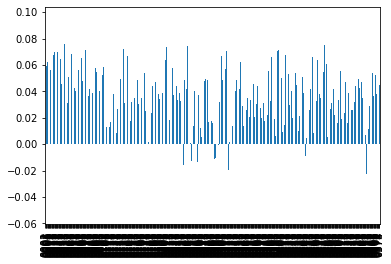

autocorrelation: 0.7387996947816111
mean correlation: 0.03564475424635572
sharpe: 1.6307559959790532
numerai sharpe: 3.9984746923577017
smart sharpe: 2.1938013657815527
predicting on validation
getting per val_era scores
performance over time


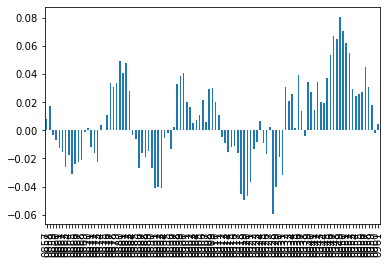

val_autocorrelation: 0.8321596729875972
val_mean correlation: 0.006185921710819827
val_sharpe: 0.21281707698496588
val numerai sharpe: -0.504027482059323
val_smart sharpe: 0.22802227929419236
current score -0.050816282358525096 did not improve from max score 0.0 on round 0
101/101 [==============================] - 272s 3s/step - loss: 0.0509 - mae: 0.1568 - mse: 0.0509 - val_loss: 0.0525 - val_mae: 0.1747 - val_mse: 0.0525
Epoch 2/48
100/101 [============================>.] - ETA: 42s - loss: 0.0520 - mae: 0.1738 - mse: 0.05 - ETA: 41s - loss: 0.0527 - mae: 0.1765 - mse: 0.05 - ETA: 41s - loss: 0.0525 - mae: 0.1748 - mse: 0.05 - ETA: 41s - loss: 0.0521 - mae: 0.1701 - mse: 0.05 - ETA: 38s - loss: 0.0520 - mae: 0.1696 - mse: 0.05 - ETA: 38s - loss: 0.0519 - mae: 0.1697 - mse: 0.05 - ETA: 36s - loss: 0.0519 - mae: 0.1691 - mse: 0.05 - ETA: 35s - loss: 0.0516 - mae: 0.1672 - mse: 0.05 - ETA: 34s - loss: 0.0516 - mae: 0.1667 - mse: 0.05 - ETA: 33s - loss: 0.0514 - mae: 0.1663 - mse: 0.05 

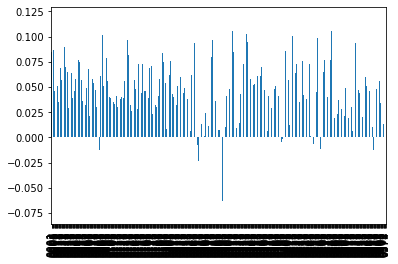

autocorrelation: 0.7870446342640004
mean correlation: 0.044774622496407276
sharpe: 1.5921793231671586
numerai sharpe: 4.232501365679201
smart sharpe: 1.9091980690044192
predicting on validation
getting per val_era scores
performance over time


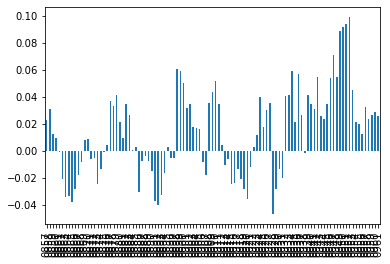

val_autocorrelation: 0.7778640039451863
val_mean correlation: 0.013692273899613977
val_sharpe: 0.43057327243010746
val numerai sharpe: 0.3569886790096743
val_smart sharpe: 0.534839353193265
saving best scored model
new max_score: 1.3497858524322748
101/101 [==============================] - 231s 2s/step - loss: 0.0501 - mae: 0.1548 - mse: 0.0501 - val_loss: 0.0515 - val_mae: 0.1688 - val_mse: 0.0515
Epoch 3/48
100/101 [============================>.] - ETA: 16s - loss: 0.0515 - mae: 0.1685 - mse: 0.05 - ETA: 17s - loss: 0.0520 - mae: 0.1715 - mse: 0.05 - ETA: 16s - loss: 0.0517 - mae: 0.1712 - mse: 0.05 - ETA: 17s - loss: 0.0512 - mae: 0.1682 - mse: 0.05 - ETA: 16s - loss: 0.0509 - mae: 0.1653 - mse: 0.05 - ETA: 16s - loss: 0.0509 - mae: 0.1650 - mse: 0.05 - ETA: 15s - loss: 0.0509 - mae: 0.1648 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1643 - mse: 0.05 - ETA: 15s - loss: 0.0507 - mae: 0.1632 - mse: 0.05 - ETA: 15s - loss: 0.0506 - mae: 0.1620 - mse: 0.05 - ETA: 14s - loss: 0.0506

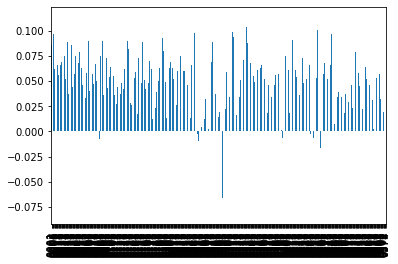

autocorrelation: 0.7750155878221328
mean correlation: 0.047210936235001146
sharpe: 1.7286173881241746
numerai sharpe: 4.667076581762224
smart sharpe: 2.137269689081466
predicting on validation
getting per val_era scores
performance over time


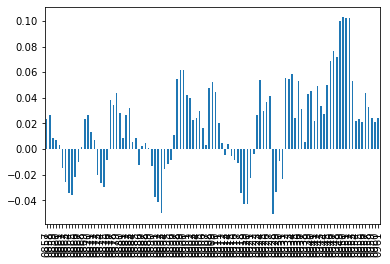

val_autocorrelation: 0.8046216320531347
val_mean correlation: 0.017448103256691112
val_sharpe: 0.5097360082966786
val numerai sharpe: 0.7117462669285769
val_smart sharpe: 0.591225785180825
saving best scored model
new max_score: 1.8476042669194628
101/101 [==============================] - 172s 2s/step - loss: 0.0500 - mae: 0.1544 - mse: 0.0500 - val_loss: 0.0506 - val_mae: 0.1615 - val_mse: 0.0506
Epoch 4/48
100/101 [============================>.] - ETA: 15s - loss: 0.0505 - mae: 0.1620 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1635 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1643 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1637 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1622 - mse: 0.05 - ETA: 14s - loss: 0.0506 - mae: 0.1621 - mse: 0.05 - ETA: 14s - loss: 0.0506 - mae: 0.1622 - mse: 0.05 - ETA: 14s - loss: 0.0506 - mae: 0.1614 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1603 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1601 - mse: 0.05 - ETA: 13s - loss: 0.0505 

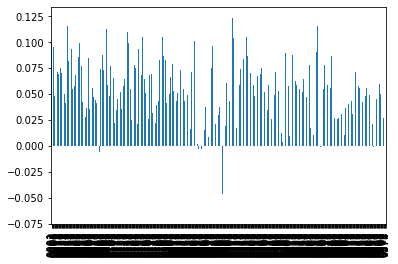

autocorrelation: 0.7665359682244308
mean correlation: 0.054140478126792735
sharpe: 1.9107773446538296
numerai sharpe: 5.345787080776511
smart sharpe: 2.4120240991319912
predicting on validation
getting per val_era scores
performance over time


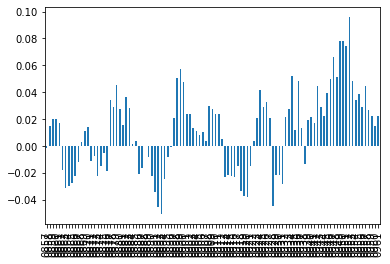

val_autocorrelation: 0.8017203975202045
val_mean correlation: 0.011389120340734658
val_sharpe: 0.37970539673154435
val numerai sharpe: 0.11248410556945546
val_smart sharpe: 0.4438550860607202
current score 0.9588228290431893 did not improve from max score 1.8476042669194628 on round 2
101/101 [==============================] - 171s 2s/step - loss: 0.0500 - mae: 0.1542 - mse: 0.0500 - val_loss: 0.0503 - val_mae: 0.1586 - val_mse: 0.0503
Epoch 5/48
100/101 [============================>.] - ETA: 17s - loss: 0.0504 - mae: 0.1587 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1600 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1599 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1591 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1584 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1581 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1576 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1573 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1567 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1563 

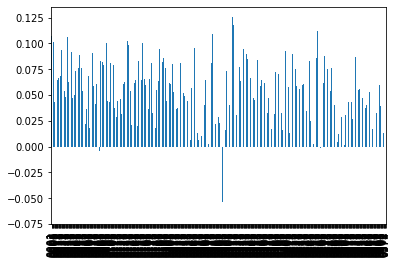

autocorrelation: 0.7670603589006127
mean correlation: 0.05432520577276298
sharpe: 1.9565490868398836
numerai sharpe: 5.478276400602731
smart sharpe: 2.4666827883920495
predicting on validation
getting per val_era scores
performance over time


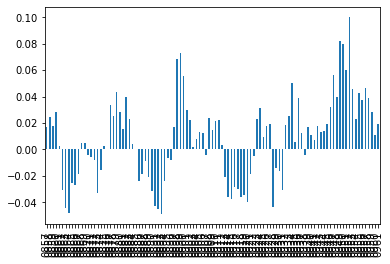

val_autocorrelation: 0.7964401742964158
val_mean correlation: 0.008171252230113418
val_sharpe: 0.262845882164043
val numerai sharpe: -0.2500385808125962
val_smart sharpe: 0.31156880956645217
current score 0.34071861537812576 did not improve from max score 1.8476042669194628 on round 2
101/101 [==============================] - 172s 2s/step - loss: 0.0499 - mae: 0.1538 - mse: 0.0499 - val_loss: 0.0505 - val_mae: 0.1609 - val_mse: 0.0505
Epoch 6/48
100/101 [============================>.] - ETA: 17s - loss: 0.0507 - mae: 0.1619 - mse: 0.05 - ETA: 15s - loss: 0.0511 - mae: 0.1648 - mse: 0.05 - ETA: 15s - loss: 0.0510 - mae: 0.1653 - mse: 0.05 - ETA: 15s - loss: 0.0511 - mae: 0.1645 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1626 - mse: 0.05 - ETA: 14s - loss: 0.0508 - mae: 0.1624 - mse: 0.05 - ETA: 14s - loss: 0.0506 - mae: 0.1620 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1619 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1608 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1599 

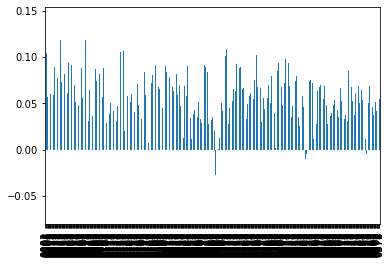

autocorrelation: 0.770612343004016
mean correlation: 0.057377778277936026
sharpe: 2.038051750401621
numerai sharpe: 5.778491248721333
smart sharpe: 2.5473626625262575
predicting on validation
getting per val_era scores
performance over time


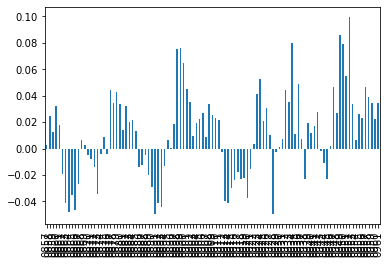

val_autocorrelation: 0.7158705648881426
val_mean correlation: 0.010755736700785268
val_sharpe: 0.3329956861726622
val numerai sharpe: 0.036526802240597074
val_smart sharpe: 0.47383486024688287
current score 0.8648688220617127 did not improve from max score 1.8476042669194628 on round 2
101/101 [==============================] - 175s 2s/step - loss: 0.0499 - mae: 0.1542 - mse: 0.0499 - val_loss: 0.0501 - val_mae: 0.1547 - val_mse: 0.0501
Epoch 7/48
100/101 [============================>.] - ETA: 17s - loss: 0.0493 - mae: 0.1529 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1547 - mse: 0.04 - ETA: 15s - loss: 0.0502 - mae: 0.1554 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1550 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1551 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1554 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1553 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1550 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1550 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1548

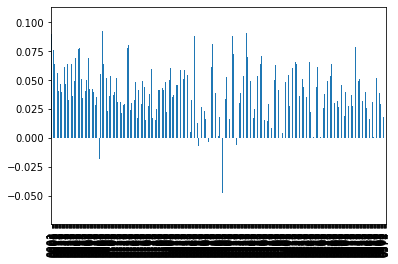

autocorrelation: 0.7752692438957444
mean correlation: 0.03938313222685112
sharpe: 1.7854986986843424
numerai sharpe: 4.549441582868029
smart sharpe: 2.206205392080615
predicting on validation
getting per val_era scores
performance over time


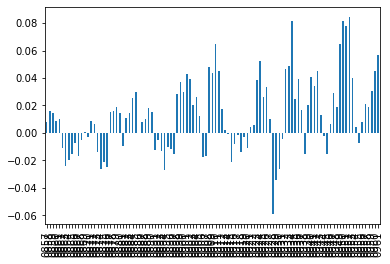

val_autocorrelation: 0.698590356866364
val_mean correlation: 0.012804028887796026
val_sharpe: 0.47053691758187344
val numerai sharpe: 0.3041102694266665
val_smart sharpe: 0.6924031456299093
current score 1.4926583904140411 did not improve from max score 1.8476042669194628 on round 2
101/101 [==============================] - 176s 2s/step - loss: 0.0498 - mae: 0.1543 - mse: 0.0498 - val_loss: 0.0507 - val_mae: 0.1609 - val_mse: 0.0507
Epoch 8/48
100/101 [============================>.] - ETA: 19s - loss: 0.0514 - mae: 0.1629 - mse: 0.05 - ETA: 18s - loss: 0.0510 - mae: 0.1625 - mse: 0.05 - ETA: 16s - loss: 0.0508 - mae: 0.1613 - mse: 0.05 - ETA: 16s - loss: 0.0506 - mae: 0.1599 - mse: 0.05 - ETA: 17s - loss: 0.0506 - mae: 0.1598 - mse: 0.05 - ETA: 17s - loss: 0.0506 - mae: 0.1600 - mse: 0.05 - ETA: 17s - loss: 0.0505 - mae: 0.1595 - mse: 0.05 - ETA: 17s - loss: 0.0504 - mae: 0.1587 - mse: 0.05 - ETA: 17s - loss: 0.0502 - mae: 0.1583 - mse: 0.05 - ETA: 16s - loss: 0.0502 - mae: 0.1578 - 

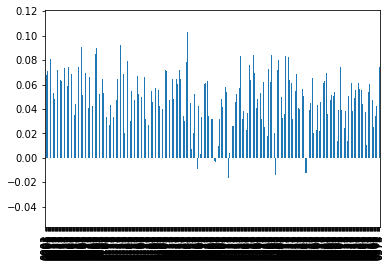

autocorrelation: 0.7709302653590812
mean correlation: 0.04839019618327862
sharpe: 1.967012005293214
numerai sharpe: 5.347348828043948
smart sharpe: 2.456658401734277
predicting on validation
getting per val_era scores
performance over time


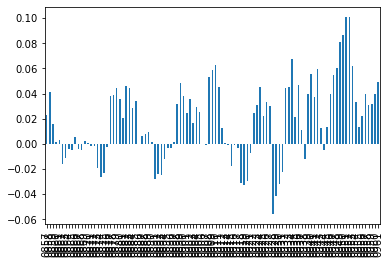

val_autocorrelation: 0.7557901699386094
val_mean correlation: 0.018145027824193395
val_sharpe: 0.5914342410375828
val numerai sharpe: 0.8727942045245077
val_smart sharpe: 0.7735352738301783
saving best scored model
new max_score: 2.2740537750406555
101/101 [==============================] - 166s 2s/step - loss: 0.0499 - mae: 0.1546 - mse: 0.0499 - val_loss: 0.0536 - val_mae: 0.1791 - val_mse: 0.0536
Epoch 9/48
100/101 [============================>.] - ETA: 16s - loss: 0.0536 - mae: 0.1795 - mse: 0.05 - ETA: 15s - loss: 0.0534 - mae: 0.1782 - mse: 0.05 - ETA: 15s - loss: 0.0523 - mae: 0.1723 - mse: 0.05 - ETA: 15s - loss: 0.0526 - mae: 0.1732 - mse: 0.05 - ETA: 14s - loss: 0.0521 - mae: 0.1704 - mse: 0.05 - ETA: 14s - loss: 0.0519 - mae: 0.1692 - mse: 0.05 - ETA: 14s - loss: 0.0518 - mae: 0.1689 - mse: 0.05 - ETA: 14s - loss: 0.0516 - mae: 0.1679 - mse: 0.05 - ETA: 14s - loss: 0.0514 - mae: 0.1663 - mse: 0.05 - ETA: 14s - loss: 0.0513 - mae: 0.1653 - mse: 0.05 - ETA: 14s - loss: 0.0512

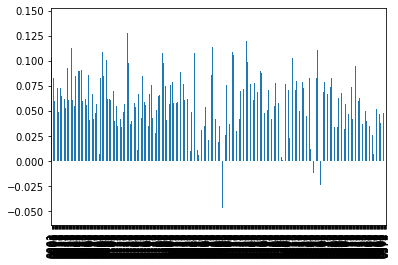

autocorrelation: 0.766856911941021
mean correlation: 0.05802225255410131
sharpe: 2.1622634600471753
numerai sharpe: 6.145770820575204
smart sharpe: 2.7273714301365284
predicting on validation
getting per val_era scores
performance over time


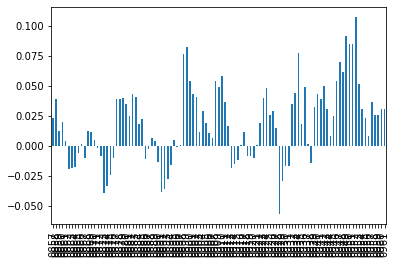

val_autocorrelation: 0.7445902448185125
val_mean correlation: 0.018566596180863412
val_sharpe: 0.5880429419883318
val numerai sharpe: 0.8943382909686467
val_smart sharpe: 0.7883475789302548
saving best scored model
new max_score: 2.3078620042489604
101/101 [==============================] - 171s 2s/step - loss: 0.0500 - mae: 0.1552 - mse: 0.0500 - val_loss: 0.0520 - val_mae: 0.1716 - val_mse: 0.0520
Epoch 10/48
100/101 [============================>.] - ETA: 19s - loss: 0.0526 - mae: 0.1730 - mse: 0.05 - ETA: 15s - loss: 0.0529 - mae: 0.1757 - mse: 0.05 - ETA: 15s - loss: 0.0527 - mae: 0.1748 - mse: 0.05 - ETA: 15s - loss: 0.0520 - mae: 0.1710 - mse: 0.05 - ETA: 16s - loss: 0.0518 - mae: 0.1681 - mse: 0.05 - ETA: 16s - loss: 0.0517 - mae: 0.1676 - mse: 0.05 - ETA: 15s - loss: 0.0516 - mae: 0.1669 - mse: 0.05 - ETA: 15s - loss: 0.0513 - mae: 0.1650 - mse: 0.05 - ETA: 15s - loss: 0.0512 - mae: 0.1645 - mse: 0.05 - ETA: 15s - loss: 0.0511 - mae: 0.1640 - mse: 0.05 - ETA: 15s - loss: 0.051

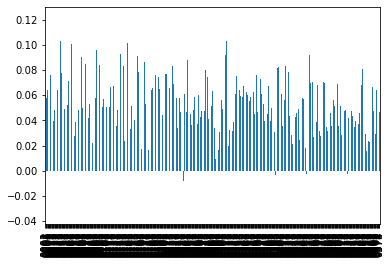

autocorrelation: 0.718816941804518
mean correlation: 0.053815438826367974
sharpe: 2.3051136892800654
numerai sharpe: 6.439744940987864
smart sharpe: 3.2352834428978254
predicting on validation
getting per val_era scores
performance over time


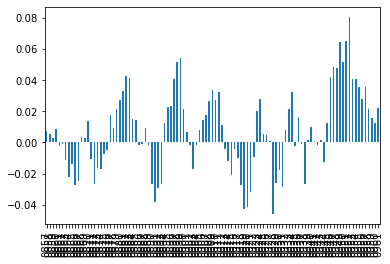

val_autocorrelation: 0.8080455423889333
val_mean correlation: 0.007634804072973822
val_sharpe: 0.29917453474070843
val numerai sharpe: -0.37741295992749957
val_smart sharpe: 0.34378085027747246
current score 0.28081203323662896 did not improve from max score 2.3078620042489604 on round 8
101/101 [==============================] - 166s 2s/step - loss: 0.0500 - mae: 0.1551 - mse: 0.0500 - val_loss: 0.0514 - val_mae: 0.1657 - val_mse: 0.0514
Epoch 11/48
100/101 [============================>.] - ETA: 17s - loss: 0.0511 - mae: 0.1651 - mse: 0.05 - ETA: 15s - loss: 0.0512 - mae: 0.1661 - mse: 0.05 - ETA: 15s - loss: 0.0510 - mae: 0.1634 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1623 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1625 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1618 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1606 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1598 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1597 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1

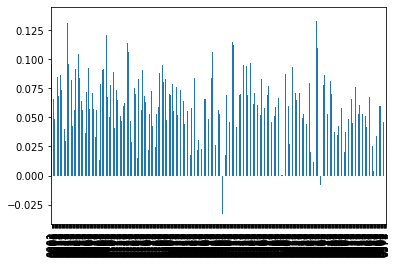

autocorrelation: 0.730238813954353
mean correlation: 0.05993019112745638
sharpe: 2.3487543849233052
numerai sharpe: 6.722327600651717
smart sharpe: 3.2186463698419634
predicting on validation
getting per val_era scores
performance over time


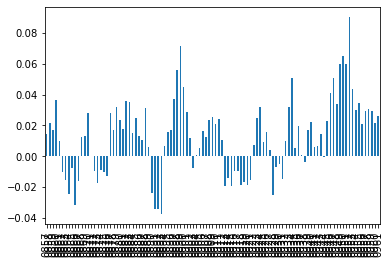

val_autocorrelation: 0.756572806890957
val_mean correlation: 0.012739236230353971
val_sharpe: 0.5248265023106231
val numerai sharpe: 0.3316763303267792
val_smart sharpe: 0.685211017340604
current score 1.5671923224387143 did not improve from max score 2.3078620042489604 on round 8
101/101 [==============================] - 167s 2s/step - loss: 0.0499 - mae: 0.1546 - mse: 0.0499 - val_loss: 0.0508 - val_mae: 0.1636 - val_mse: 0.0508
Epoch 12/48
100/101 [============================>.] - ETA: 16s - loss: 0.0504 - mae: 0.1630 - mse: 0.05 - ETA: 15s - loss: 0.0512 - mae: 0.1671 - mse: 0.05 - ETA: 15s - loss: 0.0517 - mae: 0.1693 - mse: 0.05 - ETA: 15s - loss: 0.0518 - mae: 0.1696 - mse: 0.05 - ETA: 15s - loss: 0.0515 - mae: 0.1680 - mse: 0.05 - ETA: 15s - loss: 0.0512 - mae: 0.1656 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1641 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1640 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1639 - mse: 0.05 - ETA: 14s - loss: 0.0508 - mae: 0.1636 - m

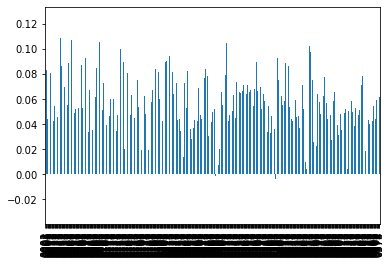

autocorrelation: 0.7360469651843116
mean correlation: 0.05708503574125498
sharpe: 2.321958821660244
numerai sharpe: 6.575966009083683
smart sharpe: 3.142446029640985
predicting on validation
getting per val_era scores
performance over time


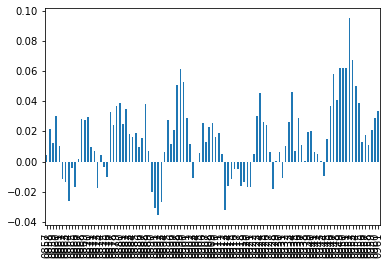

val_autocorrelation: 0.7481797647852951
val_mean correlation: 0.01474320632036993
val_sharpe: 0.6096550752495141
val numerai sharpe: 0.6199767105915723
val_smart sharpe: 0.8109515313096174
current score 2.0700697297914434 did not improve from max score 2.3078620042489604 on round 8
101/101 [==============================] - 167s 2s/step - loss: 0.0500 - mae: 0.1543 - mse: 0.0500 - val_loss: 0.0502 - val_mae: 0.1563 - val_mse: 0.0502
Epoch 13/48
100/101 [============================>.] - ETA: 17s - loss: 0.0496 - mae: 0.1552 - mse: 0.04 - ETA: 15s - loss: 0.0497 - mae: 0.1559 - mse: 0.04 - ETA: 15s - loss: 0.0500 - mae: 0.1567 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1568 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1572 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1571 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1574 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1574 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1571 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1568 - 

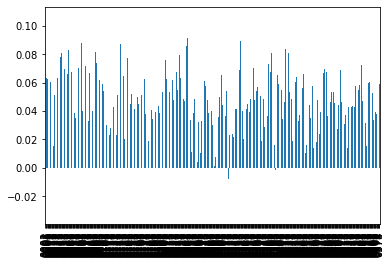

autocorrelation: 0.7145862516619877
mean correlation: 0.048032707361899775
sharpe: 2.2928072029232265
numerai sharpe: 6.220304424998145
smart sharpe: 3.24597331235472
predicting on validation
getting per val_era scores
performance over time


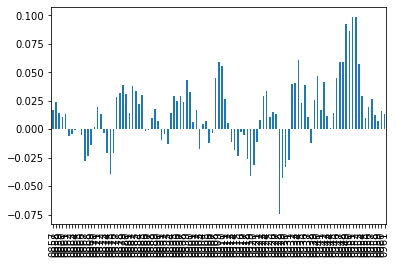

val_autocorrelation: 0.7456008015017429
val_mean correlation: 0.01394553963464904
val_sharpe: 0.4709214538918364
val numerai sharpe: 0.41297705423978653
val_smart sharpe: 0.6299476907265632
current score 1.541737278127484 did not improve from max score 2.3078620042489604 on round 8
101/101 [==============================] - 170s 2s/step - loss: 0.0498 - mae: 0.1544 - mse: 0.0498 - val_loss: 0.0525 - val_mae: 0.1743 - val_mse: 0.0525
Epoch 14/48
100/101 [============================>.] - ETA: 18s - loss: 0.0520 - mae: 0.1733 - mse: 0.05 - ETA: 15s - loss: 0.0528 - mae: 0.1766 - mse: 0.05 - ETA: 15s - loss: 0.0531 - mae: 0.1773 - mse: 0.05 - ETA: 14s - loss: 0.0525 - mae: 0.1738 - mse: 0.05 - ETA: 14s - loss: 0.0521 - mae: 0.1707 - mse: 0.05 - ETA: 14s - loss: 0.0519 - mae: 0.1704 - mse: 0.05 - ETA: 14s - loss: 0.0518 - mae: 0.1697 - mse: 0.05 - ETA: 14s - loss: 0.0516 - mae: 0.1677 - mse: 0.05 - ETA: 14s - loss: 0.0515 - mae: 0.1669 - mse: 0.05 - ETA: 13s - loss: 0.0514 - mae: 0.1664 - 

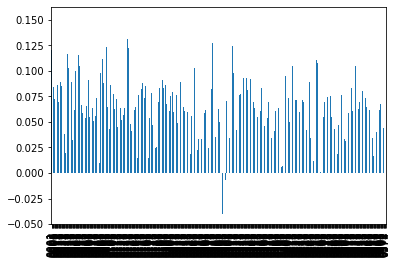

autocorrelation: 0.7503236762557947
mean correlation: 0.06349752815838096
sharpe: 2.3679871198119815
numerai sharpe: 6.857463084068061
smart sharpe: 3.1047295137428588
predicting on validation
getting per val_era scores
performance over time


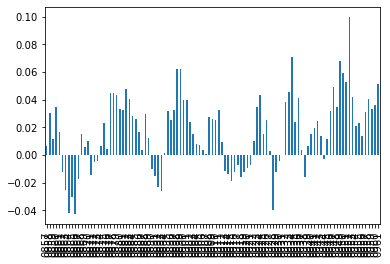

val_autocorrelation: 0.7327886211886395
val_mean correlation: 0.01640902959984456
val_sharpe: 0.6309691383179301
val numerai sharpe: 0.7984055872021895
val_smart sharpe: 0.8674053419338591
saving best scored model
new max_score: 2.3295981266536674
101/101 [==============================] - 168s 2s/step - loss: 0.0500 - mae: 0.1555 - mse: 0.0500 - val_loss: 0.0505 - val_mae: 0.1610 - val_mse: 0.0505
Epoch 15/48
100/101 [============================>.] - ETA: 16s - loss: 0.0504 - mae: 0.1610 - mse: 0.05 - ETA: 15s - loss: 0.0503 - mae: 0.1617 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1601 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1588 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1586 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1587 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1583 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1579 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1577 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1576 - mse: 0.05 - ETA: 14s - loss: 0.0502

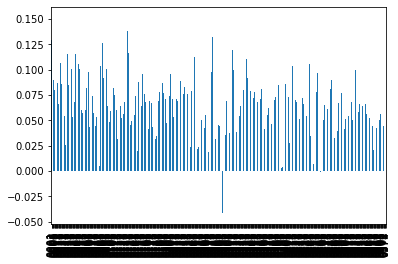

autocorrelation: 0.7503360377265234
mean correlation: 0.0637020567026718
sharpe: 2.347623455431921
numerai sharpe: 6.802774675512645
smart sharpe: 3.07794366304676
predicting on validation
getting per val_era scores
performance over time


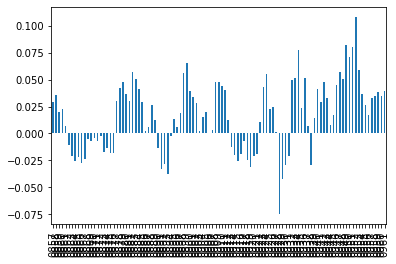

val_autocorrelation: 0.7669588875025354
val_mean correlation: 0.016491479372301363
val_sharpe: 0.5096731099634206
val numerai sharpe: 0.650524637611166
val_smart sharpe: 0.6497574191373665
current score 1.8429381254565558 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 169s 2s/step - loss: 0.0498 - mae: 0.1546 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1560 - val_mse: 0.0502
Epoch 16/48
100/101 [============================>.] - ETA: 19s - loss: 0.0488 - mae: 0.1533 - mse: 0.04 - ETA: 15s - loss: 0.0496 - mae: 0.1548 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1556 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1555 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1557 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1556 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1557 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1556 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1554 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1556 -

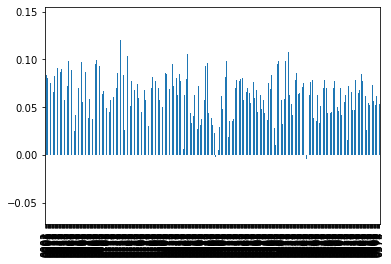

autocorrelation: 0.7550143326007532
mean correlation: 0.06307501037944661
sharpe: 2.3951220268738385
numerai sharpe: 6.926926946572671
smart sharpe: 3.1067217332137647
predicting on validation
getting per val_era scores
performance over time


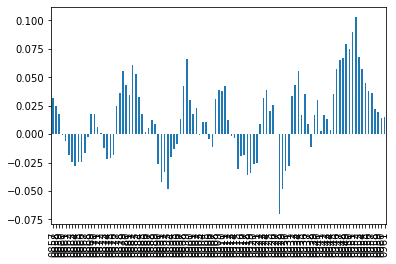

val_autocorrelation: 0.826439397963097
val_mean correlation: 0.012873663377897464
val_sharpe: 0.3938359207186957
val numerai sharpe: 0.26054075525421266
val_smart sharpe: 0.4293496420663459
current score 1.109473644795049 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 166s 2s/step - loss: 0.0498 - mae: 0.1546 - mse: 0.0498 - val_loss: 0.0504 - val_mae: 0.1581 - val_mse: 0.0504
Epoch 17/48
100/101 [============================>.] - ETA: 18s - loss: 0.0496 - mae: 0.1571 - mse: 0.04 - ETA: 19s - loss: 0.0499 - mae: 0.1576 - mse: 0.04 - ETA: 17s - loss: 0.0500 - mae: 0.1570 - mse: 0.05 - ETA: 16s - loss: 0.0501 - mae: 0.1573 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1577 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1577 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1575 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1575 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1575 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1572 -

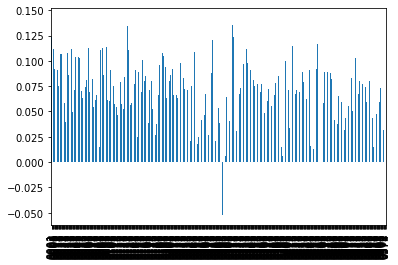

autocorrelation: 0.7759357369479815
mean correlation: 0.06857402321380109
sharpe: 2.3635663963526494
numerai sharpe: 6.944080609682928
smart sharpe: 2.915633050666249
predicting on validation
getting per val_era scores
performance over time


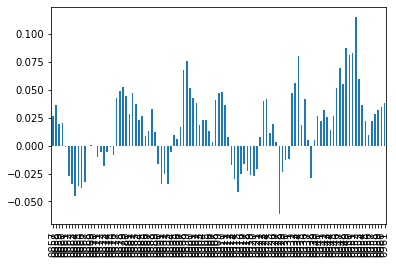

val_autocorrelation: 0.7965008533330961
val_mean correlation: 0.016182351252722764
val_sharpe: 0.4826104030711275
val numerai sharpe: 0.5958136988420657
val_smart sharpe: 0.5719796849222323
current score 1.682768489340871 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 170s 2s/step - loss: 0.0498 - mae: 0.1545 - mse: 0.0498 - val_loss: 0.0501 - val_mae: 0.1555 - val_mse: 0.0501
Epoch 18/48
100/101 [============================>.] - ETA: 19s - loss: 0.0499 - mae: 0.1557 - mse: 0.04 - ETA: 15s - loss: 0.0503 - mae: 0.1565 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1554 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1552 - mse: 0.04 - ETA: 14s - loss: 0.0497 - mae: 0.1549 - mse: 0.04 - ETA: 14s - loss: 0.0497 - mae: 0.1548 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1550 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1547 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1545 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1544 -

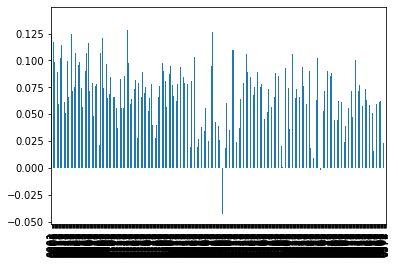

autocorrelation: 0.7843820631661437
mean correlation: 0.06644245658458658
sharpe: 2.387603199590786
numerai sharpe: 6.974399297838059
smart sharpe: 2.8828408736012205
predicting on validation
getting per val_era scores
performance over time


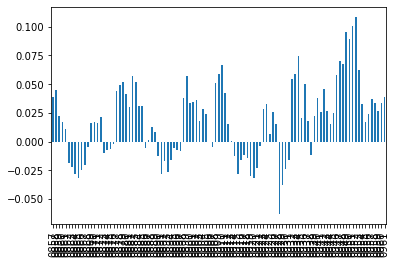

val_autocorrelation: 0.7861791518060405
val_mean correlation: 0.01873545556297465
val_sharpe: 0.569525889078102
val numerai sharpe: 0.8761508836297941
val_smart sharpe: 0.6930653633099196
current score 2.176213047143765 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 166s 2s/step - loss: 0.0497 - mae: 0.1549 - mse: 0.0497 - val_loss: 0.0524 - val_mae: 0.1732 - val_mse: 0.0524
Epoch 19/48
100/101 [============================>.] - ETA: 18s - loss: 0.0516 - mae: 0.1718 - mse: 0.05 - ETA: 15s - loss: 0.0523 - mae: 0.1751 - mse: 0.05 - ETA: 14s - loss: 0.0526 - mae: 0.1749 - mse: 0.05 - ETA: 14s - loss: 0.0518 - mae: 0.1700 - mse: 0.05 - ETA: 14s - loss: 0.0514 - mae: 0.1681 - mse: 0.05 - ETA: 14s - loss: 0.0514 - mae: 0.1683 - mse: 0.05 - ETA: 14s - loss: 0.0513 - mae: 0.1681 - mse: 0.05 - ETA: 14s - loss: 0.0513 - mae: 0.1675 - mse: 0.05 - ETA: 14s - loss: 0.0510 - mae: 0.1658 - mse: 0.05 - ETA: 14s - loss: 0.0509 - mae: 0.1648 - m

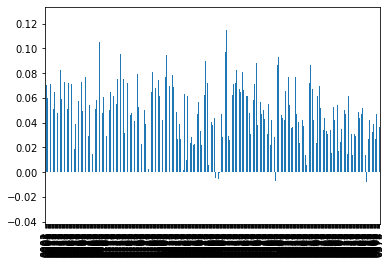

autocorrelation: 0.7447858218751181
mean correlation: 0.049196105992018256
sharpe: 1.9836113430605997
numerai sharpe: 5.416701999729597
smart sharpe: 2.6334137232597152
predicting on validation
getting per val_era scores
performance over time


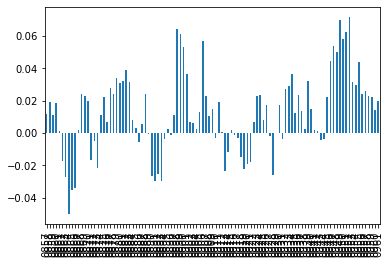

val_autocorrelation: 0.7517331830013726
val_mean correlation: 0.01227275242951103
val_sharpe: 0.4994772575185249
val numerai sharpe: 0.261888364306086
val_smart sharpe: 0.6592095750974998
current score 1.4451207017811325 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 167s 2s/step - loss: 0.0500 - mae: 0.1551 - mse: 0.0500 - val_loss: 0.0520 - val_mae: 0.1696 - val_mse: 0.0520
Epoch 20/48
100/101 [============================>.] - ETA: 19s - loss: 0.0510 - mae: 0.1678 - mse: 0.05 - ETA: 15s - loss: 0.0523 - mae: 0.1736 - mse: 0.05 - ETA: 15s - loss: 0.0526 - mae: 0.1743 - mse: 0.05 - ETA: 15s - loss: 0.0523 - mae: 0.1725 - mse: 0.05 - ETA: 15s - loss: 0.0520 - mae: 0.1699 - mse: 0.05 - ETA: 14s - loss: 0.0516 - mae: 0.1668 - mse: 0.05 - ETA: 14s - loss: 0.0516 - mae: 0.1660 - mse: 0.05 - ETA: 14s - loss: 0.0515 - mae: 0.1656 - mse: 0.05 - ETA: 14s - loss: 0.0514 - mae: 0.1652 - mse: 0.05 - ETA: 14s - loss: 0.0513 - mae: 0.1647 - 

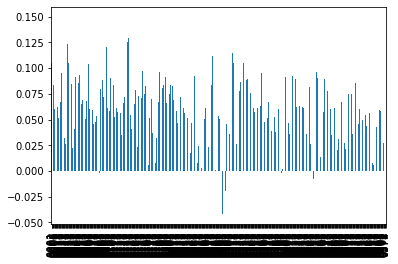

autocorrelation: 0.7563879615911665
mean correlation: 0.05863956192034388
sharpe: 2.055861227628471
numerai sharpe: 5.856802863713645
smart sharpe: 2.6581934251719677
predicting on validation
getting per val_era scores
performance over time


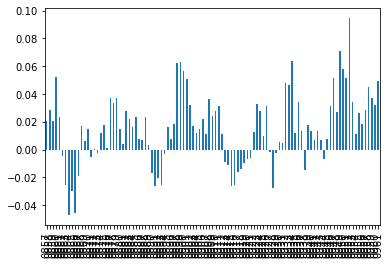

val_autocorrelation: 0.7016952796329762
val_mean correlation: 0.01533692414930911
val_sharpe: 0.6007287966776351
val numerai sharpe: 0.6678087915197558
val_smart sharpe: 0.8787681693612673
current score 2.1779796058572765 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 165s 2s/step - loss: 0.0500 - mae: 0.1550 - mse: 0.0500 - val_loss: 0.0508 - val_mae: 0.1639 - val_mse: 0.0508
Epoch 21/48
100/101 [============================>.] - ETA: 17s - loss: 0.0492 - mae: 0.1608 - mse: 0.04 - ETA: 16s - loss: 0.0502 - mae: 0.1639 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1640 - mse: 0.05 - ETA: 15s - loss: 0.0503 - mae: 0.1620 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1605 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1601 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1601 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1602 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1599 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1593 -

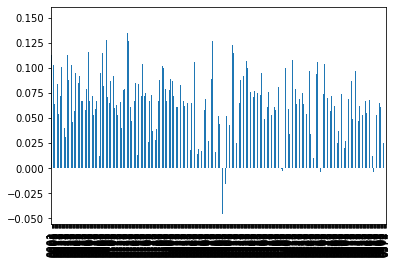

autocorrelation: 0.7548115774925162
mean correlation: 0.06422974807212824
sharpe: 2.2229164489007394
numerai sharpe: 6.451751220484812
smart sharpe: 2.8847040867734184
predicting on validation
getting per val_era scores
performance over time


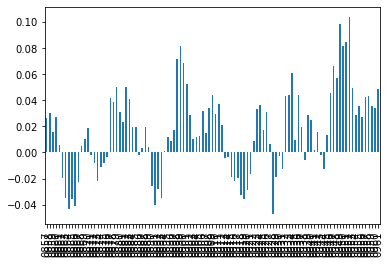

val_autocorrelation: 0.7915767747171399
val_mean correlation: 0.01640817383618464
val_sharpe: 0.5103501342873986
val numerai sharpe: 0.645720126323417
val_smart sharpe: 0.612613098605483
current score 1.8014997068886678 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 166s 2s/step - loss: 0.0499 - mae: 0.1545 - mse: 0.0499 - val_loss: 0.0501 - val_mae: 0.1553 - val_mse: 0.0501
Epoch 22/48
100/101 [============================>.] - ETA: 18s - loss: 0.0505 - mae: 0.1573 - mse: 0.05 - ETA: 15s - loss: 0.0498 - mae: 0.1552 - mse: 0.04 - ETA: 15s - loss: 0.0497 - mae: 0.1552 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1550 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1551 - mse: 0.04 - ETA: 14s - loss: 0.0496 - mae: 0.1551 - mse: 0.04 - ETA: 14s - loss: 0.0497 - mae: 0.1553 - mse: 0.04 - ETA: 14s - loss: 0.0497 - mae: 0.1555 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1558 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1558 - m

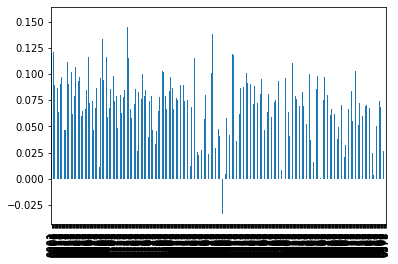

autocorrelation: 0.7566401591947427
mean correlation: 0.06889060841560951
sharpe: 2.460636458427501
numerai sharpe: 7.235218692147708
smart sharpe: 3.1796974170807055
predicting on validation
getting per val_era scores
performance over time


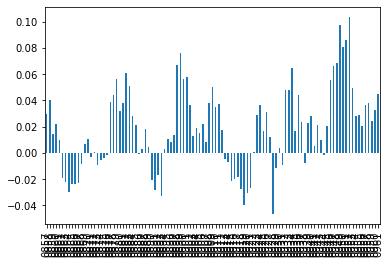

val_autocorrelation: 0.7905859908174858
val_mean correlation: 0.018252919977955473
val_sharpe: 0.5883110968837124
val numerai sharpe: 0.8750998421446258
val_smart sharpe: 0.7079872473759394
current score 2.207904026360189 did not improve from max score 2.3295981266536674 on round 13
101/101 [==============================] - 163s 2s/step - loss: 0.0498 - mae: 0.1549 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1569 - val_mse: 0.0502
Epoch 23/48
100/101 [============================>.] - ETA: 18s - loss: 0.0498 - mae: 0.1567 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1572 - mse: 0.04 - ETA: 15s - loss: 0.0500 - mae: 0.1586 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1591 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1588 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1582 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1574 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1571 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1566 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1564 -

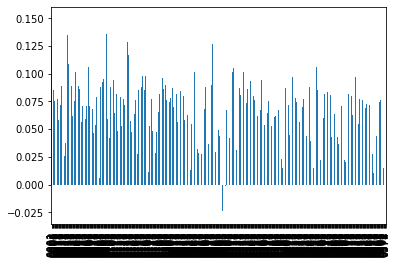

autocorrelation: 0.7523716791704593
mean correlation: 0.0667765816274772
sharpe: 2.5495619277197625
numerai sharpe: 7.454422264501121
smart sharpe: 3.3272114921011613
predicting on validation
getting per val_era scores
performance over time


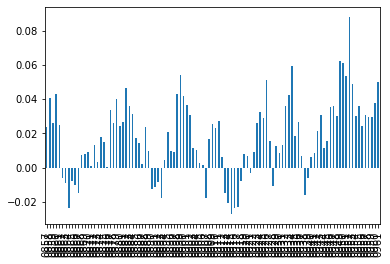

val_autocorrelation: 0.7355033753865429
val_mean correlation: 0.017470030806651035
val_sharpe: 0.7946113618243947
val numerai sharpe: 1.1115811083590914
val_smart sharpe: 1.0861636075100678
saving best scored model
new max_score: 3.027296139306856
101/101 [==============================] - 164s 2s/step - loss: 0.0498 - mae: 0.1546 - mse: 0.0498 - val_loss: 0.0513 - val_mae: 0.1674 - val_mse: 0.0513
Epoch 24/48
100/101 [============================>.] - ETA: 18s - loss: 0.0507 - mae: 0.1665 - mse: 0.05 - ETA: 15s - loss: 0.0514 - mae: 0.1709 - mse: 0.05 - ETA: 15s - loss: 0.0517 - mae: 0.1724 - mse: 0.05 - ETA: 15s - loss: 0.0515 - mae: 0.1707 - mse: 0.05 - ETA: 15s - loss: 0.0513 - mae: 0.1680 - mse: 0.05 - ETA: 15s - loss: 0.0510 - mae: 0.1667 - mse: 0.05 - ETA: 15s - loss: 0.0509 - mae: 0.1659 - mse: 0.05 - ETA: 15s - loss: 0.0507 - mae: 0.1649 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1638 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1630 - mse: 0.05 - ETA: 14s - loss: 0.0506

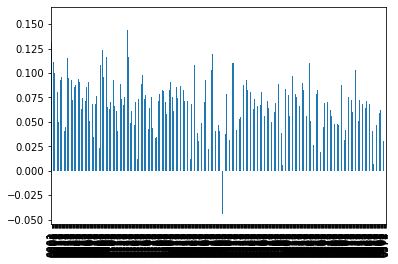

autocorrelation: 0.7362132732459437
mean correlation: 0.06700346240057563
sharpe: 2.6700809029859154
numerai sharpe: 7.81168117856012
smart sharpe: 3.612276641974406
predicting on validation
getting per val_era scores
performance over time


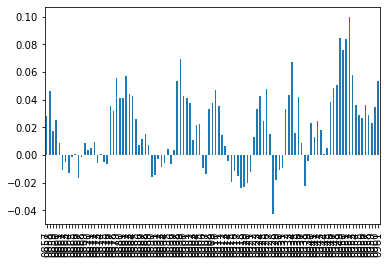

val_autocorrelation: 0.7504333855515349
val_mean correlation: 0.018682938140809388
val_sharpe: 0.6834230068450967
val numerai sharpe: 1.0476691877277362
val_smart sharpe: 0.9045794349791055
current score 2.673037505833557 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 168s 2s/step - loss: 0.0499 - mae: 0.1549 - mse: 0.0499 - val_loss: 0.0500 - val_mae: 0.1544 - val_mse: 0.0500
Epoch 25/48
100/101 [============================>.] - ETA: 19s - loss: 0.0500 - mae: 0.1549 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1550 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1547 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1553 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1547 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1546 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1546 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1544 - mse: 0.05 - ETA: 15s - loss: 0.0500 - mae: 0.1544 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1542 - 

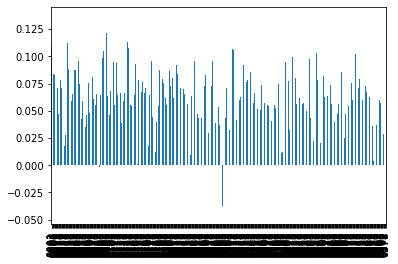

autocorrelation: 0.7231873474748994
mean correlation: 0.061423153028868034
sharpe: 2.5033622830976197
numerai sharpe: 7.201459265970865
smart sharpe: 3.4818700809113516
predicting on validation
getting per val_era scores
performance over time


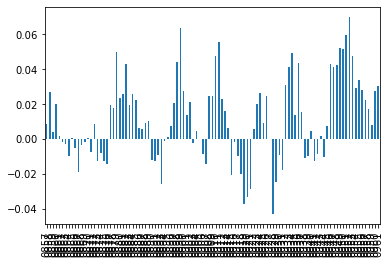

val_autocorrelation: 0.7235253897065858
val_mean correlation: 0.01120077858752601
val_sharpe: 0.4774560624939011
val numerai sharpe: 0.11600878808252856
val_smart sharpe: 0.6690178127905915
current score 1.2848842205420732 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 165s 2s/step - loss: 0.0498 - mae: 0.1543 - mse: 0.0498 - val_loss: 0.0509 - val_mae: 0.1641 - val_mse: 0.0509
Epoch 26/48
100/101 [============================>.] - ETA: 18s - loss: 0.0499 - mae: 0.1627 - mse: 0.04 - ETA: 15s - loss: 0.0507 - mae: 0.1662 - mse: 0.05 - ETA: 15s - loss: 0.0506 - mae: 0.1656 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1635 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1623 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1624 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1618 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1609 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1605 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1601 -

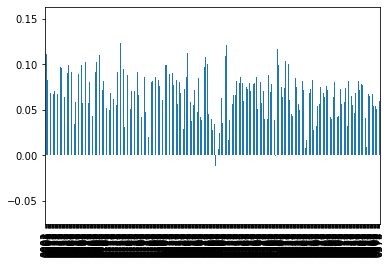

autocorrelation: 0.7505969136401034
mean correlation: 0.06795105052998193
sharpe: 2.4665334558797305
numerai sharpe: 7.2346969336463545
smart sharpe: 3.231926566749624
predicting on validation
getting per val_era scores
performance over time


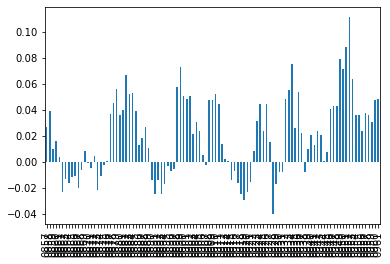

val_autocorrelation: 0.7746916449401037
val_mean correlation: 0.019929689034506516
val_sharpe: 0.663417998755228
val numerai sharpe: 1.0971472531673303
val_smart sharpe: 0.8304093328452835
current score 2.6308339628368547 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 165s 2s/step - loss: 0.0498 - mae: 0.1548 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1568 - val_mse: 0.0502
Epoch 27/48
100/101 [============================>.] - ETA: 18s - loss: 0.0495 - mae: 0.1558 - mse: 0.04 - ETA: 15s - loss: 0.0502 - mae: 0.1589 - mse: 0.05 - ETA: 15s - loss: 0.0500 - mae: 0.1592 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1597 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1594 - mse: 0.05 - ETA: 15s - loss: 0.0500 - mae: 0.1587 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1582 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1582 - mse: 0.04 - ETA: 15s - loss: 0.0501 - mae: 0.1585 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1583 - 

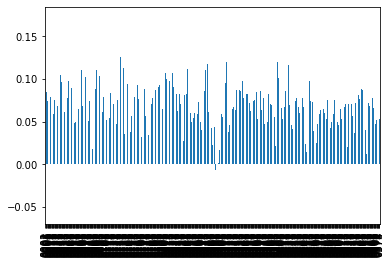

autocorrelation: 0.7448511720905986
mean correlation: 0.0693987276717192
sharpe: 2.554991539613259
numerai sharpe: 7.52245611709805
smart sharpe: 3.3914750376717717
predicting on validation
getting per val_era scores
performance over time


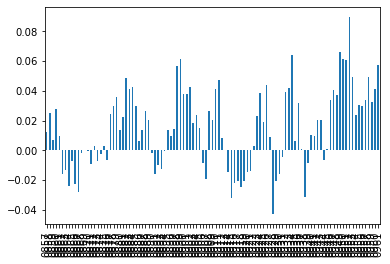

val_autocorrelation: 0.7232324937074265
val_mean correlation: 0.014645011148813248
val_sharpe: 0.5591202831916497
val numerai sharpe: 0.5594121110077452
val_smart sharpe: 0.7839132100148625
current score 1.931735626511884 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 167s 2s/step - loss: 0.0498 - mae: 0.1548 - mse: 0.0498 - val_loss: 0.0508 - val_mae: 0.1637 - val_mse: 0.0508
Epoch 28/48
100/101 [============================>.] - ETA: 18s - loss: 0.0505 - mae: 0.1624 - mse: 0.05 - ETA: 14s - loss: 0.0512 - mae: 0.1674 - mse: 0.05 - ETA: 14s - loss: 0.0513 - mae: 0.1694 - mse: 0.05 - ETA: 14s - loss: 0.0515 - mae: 0.1706 - mse: 0.05 - ETA: 14s - loss: 0.0515 - mae: 0.1706 - mse: 0.05 - ETA: 14s - loss: 0.0514 - mae: 0.1696 - mse: 0.05 - ETA: 14s - loss: 0.0512 - mae: 0.1681 - mse: 0.05 - ETA: 14s - loss: 0.0510 - mae: 0.1663 - mse: 0.05 - ETA: 14s - loss: 0.0508 - mae: 0.1648 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1638 - 

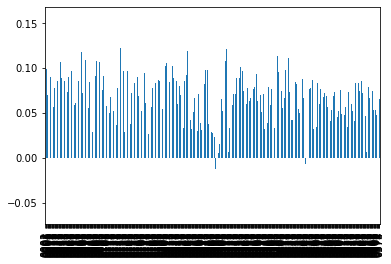

autocorrelation: 0.7538464154434642
mean correlation: 0.0675606097911289
sharpe: 2.3193037111313033
numerai sharpe: 6.795734232317052
smart sharpe: 3.016491565151699
predicting on validation
getting per val_era scores
performance over time


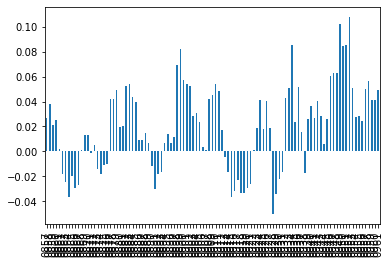

val_autocorrelation: 0.7827756795189121
val_mean correlation: 0.019689422184853964
val_sharpe: 0.5826394231624593
val numerai sharpe: 0.9506861543617777
val_smart sharpe: 0.7150624658206693
current score 2.2877668877146142 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 164s 2s/step - loss: 0.0500 - mae: 0.1546 - mse: 0.0500 - val_loss: 0.0501 - val_mae: 0.1562 - val_mse: 0.0501
Epoch 29/48
100/101 [============================>.] - ETA: 17s - loss: 0.0499 - mae: 0.1560 - mse: 0.04 - ETA: 15s - loss: 0.0500 - mae: 0.1565 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1569 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1570 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1571 - mse: 0.05 - ETA: 14s - loss: 0.0500 - mae: 0.1574 - mse: 0.05 - ETA: 14s - loss: 0.0499 - mae: 0.1574 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1573 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1575 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1575 -

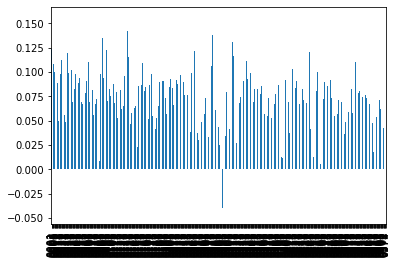

autocorrelation: 0.7453957421425371
mean correlation: 0.07207543632920879
sharpe: 2.664069162840938
numerai sharpe: 7.895040228924621
smart sharpe: 3.5319633870044136
predicting on validation
getting per val_era scores
performance over time


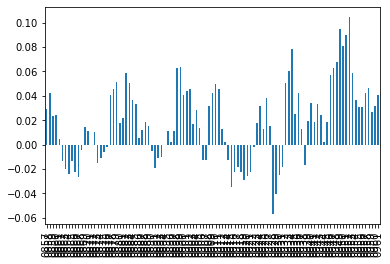

val_autocorrelation: 0.7757156814099228
val_mean correlation: 0.018600048855833728
val_sharpe: 0.5901642125103664
val numerai sharpe: 0.8996270663853361
val_smart sharpe: 0.7368983815211041
current score 2.263889758128474 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 165s 2s/step - loss: 0.0497 - mae: 0.1553 - mse: 0.0497 - val_loss: 0.0503 - val_mae: 0.1586 - val_mse: 0.0503
Epoch 30/48
100/101 [============================>.] - ETA: 16s - loss: 0.0502 - mae: 0.1581 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1596 - mse: 0.05 - ETA: 15s - loss: 0.0500 - mae: 0.1594 - mse: 0.05 - ETA: 14s - loss: 0.0499 - mae: 0.1588 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1582 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1583 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1583 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1581 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1578 - mse: 0.04 - ETA: 14s - loss: 0.0497 - mae: 0.1576 - 

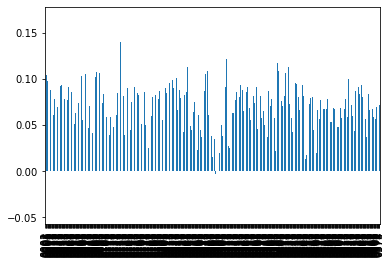

autocorrelation: 0.7641122753517176
mean correlation: 0.07120274388350661
sharpe: 2.6285319279951223
numerai sharpe: 7.773597935482521
smart sharpe: 3.337402399864724
predicting on validation
getting per val_era scores
performance over time


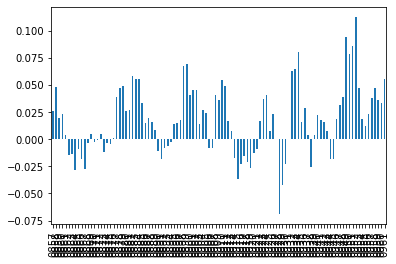

val_autocorrelation: 0.7445063140272618
val_mean correlation: 0.017491292573716847
val_sharpe: 0.5542830782755402
val numerai sharpe: 0.7767775551716943
val_smart sharpe: 0.7432232772733118
current score 2.1092664958679803 did not improve from max score 3.027296139306856 on round 22
101/101 [==============================] - 898s 9s/step - loss: 0.0497 - mae: 0.1554 - mse: 0.0497 - val_loss: 0.0506 - val_mae: 0.1599 - val_mse: 0.0506
Epoch 31/48
100/101 [============================>.] - ETA: 17s - loss: 0.0505 - mae: 0.1601 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1628 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1635 - mse: 0.05 - ETA: 15s - loss: 0.0509 - mae: 0.1634 - mse: 0.05 - ETA: 14s - loss: 0.0507 - mae: 0.1622 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1616 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1611 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1606 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1602 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1600 -

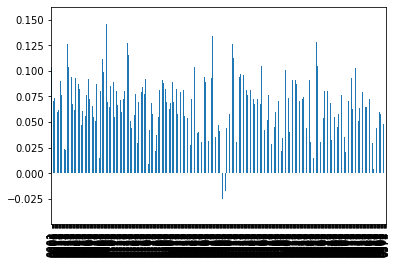

autocorrelation: 0.752068508254166
mean correlation: 0.06543384099573828
sharpe: 2.3758380723537122
numerai sharpe: 6.920146173457908
smart sharpe: 3.10265169390259
predicting on validation
getting per val_era scores
performance over time


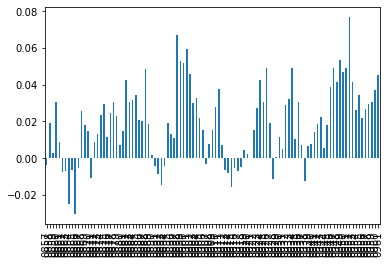

val_autocorrelation: 0.6774118547007585
val_mean correlation: 0.018832666233168222
val_sharpe: 0.9089878142939948
val numerai sharpe: 1.4074099947944638
val_smart sharpe: 1.390963580074948
saving best scored model
new max_score: 3.745026721629743
101/101 [==============================] - 190s 2s/step - loss: 0.0498 - mae: 0.1552 - mse: 0.0498 - val_loss: 0.0508 - val_mae: 0.1634 - val_mse: 0.0508
Epoch 32/48
100/101 [============================>.] - ETA: 18s - loss: 0.0500 - mae: 0.1622 - mse: 0.05 - ETA: 17s - loss: 0.0512 - mae: 0.1669 - mse: 0.05 - ETA: 17s - loss: 0.0512 - mae: 0.1682 - mse: 0.05 - ETA: 17s - loss: 0.0510 - mae: 0.1675 - mse: 0.05 - ETA: 16s - loss: 0.0508 - mae: 0.1655 - mse: 0.05 - ETA: 16s - loss: 0.0508 - mae: 0.1638 - mse: 0.05 - ETA: 16s - loss: 0.0507 - mae: 0.1632 - mse: 0.05 - ETA: 16s - loss: 0.0506 - mae: 0.1625 - mse: 0.05 - ETA: 16s - loss: 0.0505 - mae: 0.1615 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1607 - mse: 0.05 - ETA: 15s - loss: 0.0505 

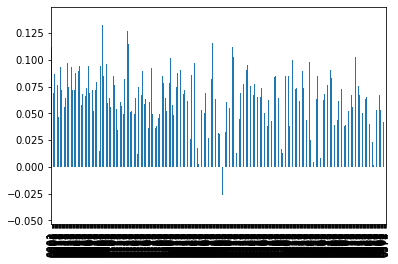

autocorrelation: 0.7513160914600249
mean correlation: 0.06236150850310752
sharpe: 2.4445568614056015
numerai sharpe: 7.053898878588012
smart sharpe: 3.1978851373568626
predicting on validation
getting per val_era scores
performance over time


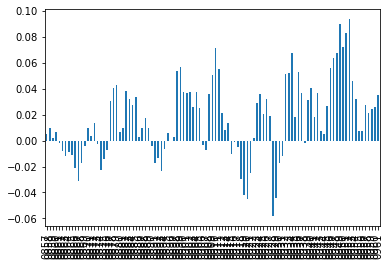

val_autocorrelation: 0.7548732150801659
val_mean correlation: 0.016451527745660447
val_sharpe: 0.5528040731333175
val numerai sharpe: 0.7026381796992515
val_smart sharpe: 0.7245005633891833
current score 2.0128458717130733 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 186s 2s/step - loss: 0.0499 - mae: 0.1549 - mse: 0.0499 - val_loss: 0.0522 - val_mae: 0.1719 - val_mse: 0.0522
Epoch 33/48
100/101 [============================>.] - ETA: 21s - loss: 0.0508 - mae: 0.1692 - mse: 0.05 - ETA: 18s - loss: 0.0526 - mae: 0.1757 - mse: 0.05 - ETA: 17s - loss: 0.0531 - mae: 0.1771 - mse: 0.05 - ETA: 17s - loss: 0.0526 - mae: 0.1749 - mse: 0.05 - ETA: 17s - loss: 0.0522 - mae: 0.1716 - mse: 0.05 - ETA: 17s - loss: 0.0518 - mae: 0.1684 - mse: 0.05 - ETA: 17s - loss: 0.0515 - mae: 0.1665 - mse: 0.05 - ETA: 17s - loss: 0.0513 - mae: 0.1652 - mse: 0.05 - ETA: 17s - loss: 0.0512 - mae: 0.1645 - mse: 0.05 - ETA: 16s - loss: 0.0511 - mae: 0.1638 -

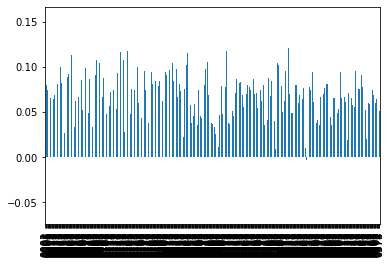

autocorrelation: 0.7343527281698825
mean correlation: 0.06940070619094808
sharpe: 2.618763097991817
numerai sharpe: 7.710252400926763
smart sharpe: 3.557144368889489
predicting on validation
getting per val_era scores
performance over time


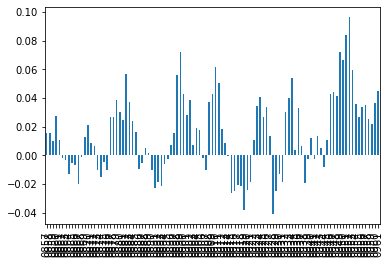

val_autocorrelation: 0.7678644938670021
val_mean correlation: 0.014979829810275725
val_sharpe: 0.5472254035846806
val numerai sharpe: 0.5776435558515559
val_smart sharpe: 0.6961543547805827
current score 1.8509829738373706 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 193s 2s/step - loss: 0.0499 - mae: 0.1551 - mse: 0.0499 - val_loss: 0.0506 - val_mae: 0.1606 - val_mse: 0.0506
Epoch 34/48
100/101 [============================>.] - ETA: 19s - loss: 0.0505 - mae: 0.1603 - mse: 0.05 - ETA: 19s - loss: 0.0504 - mae: 0.1612 - mse: 0.05 - ETA: 18s - loss: 0.0505 - mae: 0.1611 - mse: 0.05 - ETA: 18s - loss: 0.0505 - mae: 0.1600 - mse: 0.05 - ETA: 18s - loss: 0.0504 - mae: 0.1593 - mse: 0.05 - ETA: 17s - loss: 0.0504 - mae: 0.1591 - mse: 0.05 - ETA: 17s - loss: 0.0504 - mae: 0.1587 - mse: 0.05 - ETA: 17s - loss: 0.0503 - mae: 0.1585 - mse: 0.05 - ETA: 17s - loss: 0.0503 - mae: 0.1583 - mse: 0.05 - ETA: 17s - loss: 0.0503 - mae: 0.1579 -

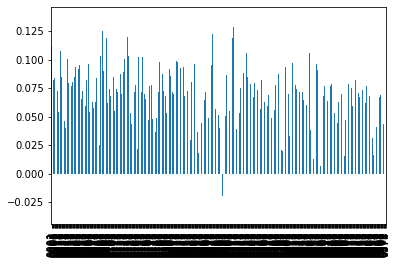

autocorrelation: 0.7221375725377865
mean correlation: 0.06823269795581606
sharpe: 2.7836577433605396
numerai sharpe: 8.17096885665207
smart sharpe: 3.8801957986942672
predicting on validation
getting per val_era scores
performance over time


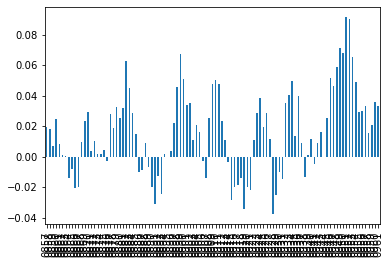

val_autocorrelation: 0.787207497646235
val_mean correlation: 0.01609072512361541
val_sharpe: 0.592973799027834
val numerai sharpe: 0.7245361878693044
val_smart sharpe: 0.7197368386709777
current score 2.069428275815347 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 199s 2s/step - loss: 0.0498 - mae: 0.1548 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1559 - val_mse: 0.0502
Epoch 35/48
100/101 [============================>.] - ETA: 20s - loss: 0.0502 - mae: 0.1556 - mse: 0.05 - ETA: 19s - loss: 0.0503 - mae: 0.1560 - mse: 0.05 - ETA: 18s - loss: 0.0500 - mae: 0.1558 - mse: 0.05 - ETA: 18s - loss: 0.0501 - mae: 0.1564 - mse: 0.05 - ETA: 18s - loss: 0.0500 - mae: 0.1565 - mse: 0.05 - ETA: 17s - loss: 0.0500 - mae: 0.1566 - mse: 0.05 - ETA: 17s - loss: 0.0500 - mae: 0.1567 - mse: 0.05 - ETA: 17s - loss: 0.0500 - mae: 0.1567 - mse: 0.05 - ETA: 17s - loss: 0.0500 - mae: 0.1565 - mse: 0.05 - ETA: 17s - loss: 0.0500 - mae: 0.1565 - mse

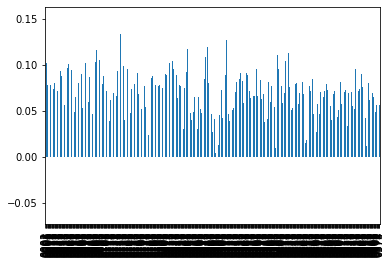

autocorrelation: 0.7488116269434375
mean correlation: 0.07074796488035538
sharpe: 2.6449441753078324
numerai sharpe: 7.813520231658704
smart sharpe: 3.4797683579189065
predicting on validation
getting per val_era scores
performance over time


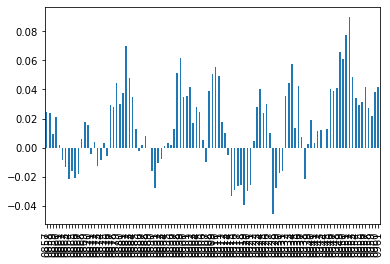

val_autocorrelation: 0.7757476663776777
val_mean correlation: 0.015149195999607712
val_sharpe: 0.5466932057645766
val numerai sharpe: 0.5918025357353244
val_smart sharpe: 0.6825664155143992
current score 1.8513605490135157 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 192s 2s/step - loss: 0.0498 - mae: 0.1549 - mse: 0.0498 - val_loss: 0.0503 - val_mae: 0.1582 - val_mse: 0.0503
Epoch 36/48
100/101 [============================>.] - ETA: 20s - loss: 0.0503 - mae: 0.1587 - mse: 0.05 - ETA: 18s - loss: 0.0505 - mae: 0.1612 - mse: 0.05 - ETA: 18s - loss: 0.0506 - mae: 0.1626 - mse: 0.05 - ETA: 18s - loss: 0.0506 - mae: 0.1628 - mse: 0.05 - ETA: 17s - loss: 0.0506 - mae: 0.1624 - mse: 0.05 - ETA: 17s - loss: 0.0505 - mae: 0.1616 - mse: 0.05 - ETA: 17s - loss: 0.0504 - mae: 0.1607 - mse: 0.05 - ETA: 17s - loss: 0.0502 - mae: 0.1596 - mse: 0.05 - ETA: 17s - loss: 0.0502 - mae: 0.1591 - mse: 0.05 - ETA: 16s - loss: 0.0502 - mae: 0.1587 -

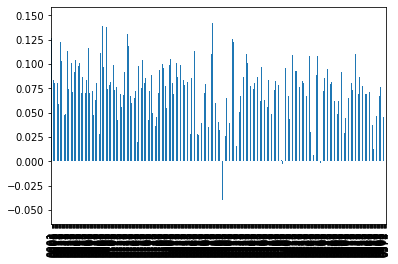

autocorrelation: 0.7699406410483866
mean correlation: 0.07141843108633046
sharpe: 2.500641010725442
numerai sharpe: 7.399201131292873
smart sharpe: 3.130684585500968
predicting on validation
getting per val_era scores
performance over time


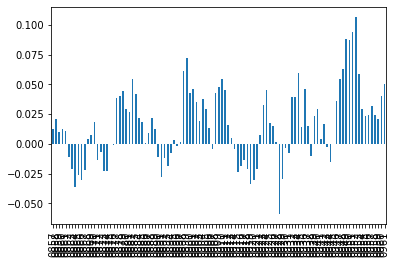

val_autocorrelation: 0.780506932676745
val_mean correlation: 0.01600011487772377
val_sharpe: 0.5197279995422845
val numerai sharpe: 0.6284399304159279
val_smart sharpe: 0.6414297023401354
current score 1.8215978620537956 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 193s 2s/step - loss: 0.0498 - mae: 0.1545 - mse: 0.0498 - val_loss: 0.0503 - val_mae: 0.1572 - val_mse: 0.0503
Epoch 37/48
100/101 [============================>.] - ETA: 25s - loss: 0.0499 - mae: 0.1569 - mse: 0.04 - ETA: 22s - loss: 0.0502 - mae: 0.1585 - mse: 0.05 - ETA: 21s - loss: 0.0501 - mae: 0.1589 - mse: 0.05 - ETA: 21s - loss: 0.0502 - mae: 0.1592 - mse: 0.05 - ETA: 21s - loss: 0.0500 - mae: 0.1586 - mse: 0.05 - ETA: 20s - loss: 0.0501 - mae: 0.1583 - mse: 0.05 - ETA: 19s - loss: 0.0499 - mae: 0.1576 - mse: 0.04 - ETA: 19s - loss: 0.0498 - mae: 0.1571 - mse: 0.04 - ETA: 18s - loss: 0.0497 - mae: 0.1567 - mse: 0.04 - ETA: 18s - loss: 0.0498 - mae: 0.1566 - m

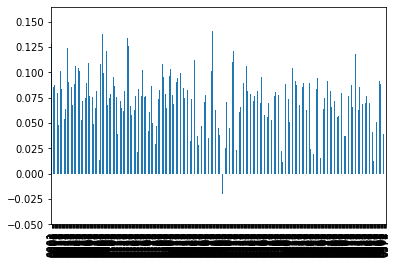

autocorrelation: 0.7677543368885563
mean correlation: 0.07186954885196571
sharpe: 2.712314357159724
numerai sharpe: 8.034126650185318
smart sharpe: 3.4137710354725623
predicting on validation
getting per val_era scores
performance over time


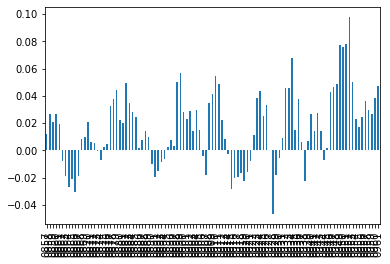

val_autocorrelation: 0.7476192937076549
val_mean correlation: 0.016575156107164493
val_sharpe: 0.6202958928172639
val numerai sharpe: 0.7985695789485414
val_smart sharpe: 0.8261192903598846
current score 2.2781350743400193 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 185s 2s/step - loss: 0.0497 - mae: 0.1546 - mse: 0.0497 - val_loss: 0.0501 - val_mae: 0.1548 - val_mse: 0.0501
Epoch 38/48
100/101 [============================>.] - ETA: 20s - loss: 0.0499 - mae: 0.1540 - mse: 0.04 - ETA: 16s - loss: 0.0500 - mae: 0.1543 - mse: 0.05 - ETA: 17s - loss: 0.0496 - mae: 0.1535 - mse: 0.04 - ETA: 16s - loss: 0.0496 - mae: 0.1533 - mse: 0.04 - ETA: 16s - loss: 0.0496 - mae: 0.1534 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1533 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1535 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1533 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1532 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1533 -

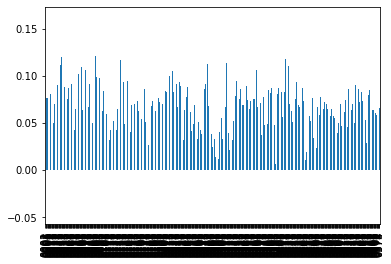

autocorrelation: 0.7645977276517879
mean correlation: 0.06875285667597525
sharpe: 2.6614258169557967
numerai sharpe: 7.822824069917192
smart sharpe: 3.3752502539022506
predicting on validation
getting per val_era scores
performance over time


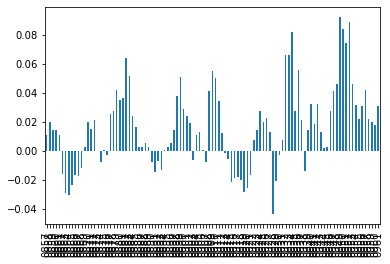

val_autocorrelation: 0.7779685506988384
val_mean correlation: 0.015950633799073313
val_sharpe: 0.5759262455077067
val numerai sharpe: 0.6923645431074086
val_smart sharpe: 0.7152087042229113
current score 2.015400760436173 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 177s 2s/step - loss: 0.0498 - mae: 0.1537 - mse: 0.0498 - val_loss: 0.0504 - val_mae: 0.1584 - val_mse: 0.0504
Epoch 39/48
100/101 [============================>.] - ETA: 19s - loss: 0.0502 - mae: 0.1579 - mse: 0.05 - ETA: 17s - loss: 0.0503 - mae: 0.1590 - mse: 0.05 - ETA: 16s - loss: 0.0505 - mae: 0.1598 - mse: 0.05 - ETA: 16s - loss: 0.0503 - mae: 0.1593 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1590 - mse: 0.05 - ETA: 15s - loss: 0.0503 - mae: 0.1582 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1577 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1570 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1567 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1562 - 

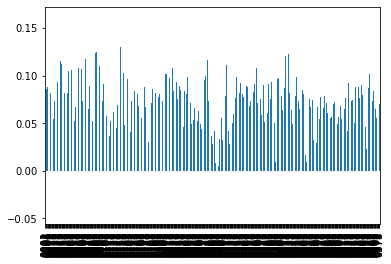

autocorrelation: 0.772464727961641
mean correlation: 0.07405453656525636
sharpe: 2.779321926074779
numerai sharpe: 8.273776128233308
smart sharpe: 3.458123115656413
predicting on validation
getting per val_era scores
performance over time


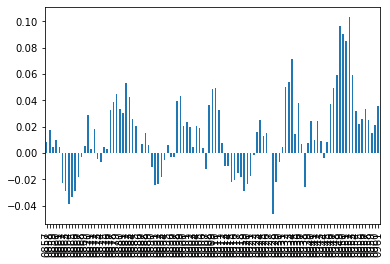

val_autocorrelation: 0.7972276546109848
val_mean correlation: 0.013941091648115477
val_sharpe: 0.4834053865438448
val numerai sharpe: 0.42352588072996583
val_smart sharpe: 0.5718328965736708
current score 1.5066463471437124 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 171s 2s/step - loss: 0.0497 - mae: 0.1546 - mse: 0.0497 - val_loss: 0.0502 - val_mae: 0.1560 - val_mse: 0.0502
Epoch 40/48
100/101 [============================>.] - ETA: 18s - loss: 0.0504 - mae: 0.1568 - mse: 0.05 - ETA: 15s - loss: 0.0497 - mae: 0.1554 - mse: 0.04 - ETA: 15s - loss: 0.0497 - mae: 0.1556 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1559 - mse: 0.04 - ETA: 14s - loss: 0.0500 - mae: 0.1560 - mse: 0.05 - ETA: 14s - loss: 0.0497 - mae: 0.1553 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1552 - mse: 0.04 - ETA: 14s - loss: 0.0499 - mae: 0.1553 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1552 - mse: 0.04 - ETA: 14s - loss: 0.0498 - mae: 0.1551 

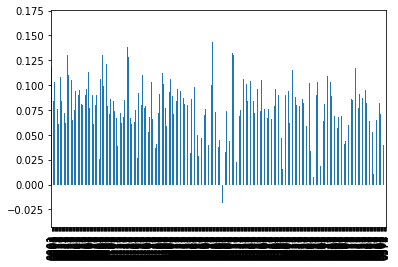

autocorrelation: 0.7735571049825335
mean correlation: 0.07652682148194727
sharpe: 2.8675329522490416
numerai sharpe: 8.581505320196708
smart sharpe: 3.5582742567527847
predicting on validation
getting per val_era scores
performance over time


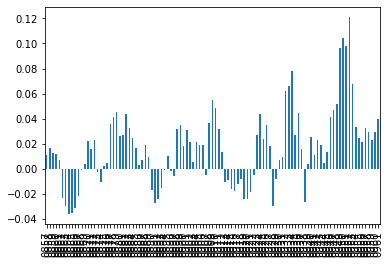

val_autocorrelation: 0.8031434350832345
val_mean correlation: 0.0170474063529333
val_sharpe: 0.5696720548147106
val numerai sharpe: 0.7677472470193389
val_smart sharpe: 0.6633818162118988
current score 2.0348959307518153 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 172s 2s/step - loss: 0.0497 - mae: 0.1548 - mse: 0.0497 - val_loss: 0.0505 - val_mae: 0.1594 - val_mse: 0.0505
Epoch 41/48
100/101 [============================>.] - ETA: 17s - loss: 0.0506 - mae: 0.1596 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1616 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1624 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1617 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1613 - mse: 0.05 - ETA: 15s - loss: 0.0503 - mae: 0.1608 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1602 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1598 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1592 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1588 - m

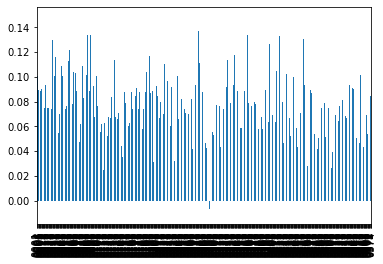

autocorrelation: 0.7382628231713039
mean correlation: 0.0763766950533823
sharpe: 2.968642366956194
numerai sharpe: 8.881338765292062
smart sharpe: 3.9983063613690843
predicting on validation
getting per val_era scores
performance over time


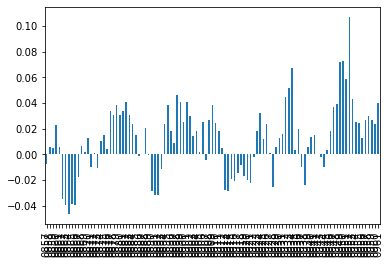

val_autocorrelation: 0.7431917464267158
val_mean correlation: 0.011753345364770663
val_sharpe: 0.4377685826578123
val numerai sharpe: 0.1726600803308748
val_smart sharpe: 0.5886628835863874
current score 1.2225982373046158 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 171s 2s/step - loss: 0.0497 - mae: 0.1550 - mse: 0.0497 - val_loss: 0.0502 - val_mae: 0.1563 - val_mse: 0.0502
Epoch 42/48
100/101 [============================>.] - ETA: 17s - loss: 0.0500 - mae: 0.1561 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1569 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1568 - mse: 0.04 - ETA: 15s - loss: 0.0501 - mae: 0.1572 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1574 - mse: 0.05 - ETA: 15s - loss: 0.0502 - mae: 0.1572 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1571 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1569 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1568 - mse: 0.05 - ETA: 14s - loss: 0.0501 - mae: 0.1567 -

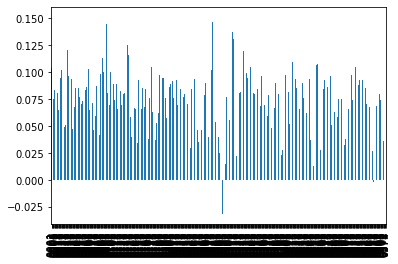

autocorrelation: 0.7669378145518332
mean correlation: 0.0734910011690769
sharpe: 2.7961088831429763
numerai sharpe: 8.313303399722788
smart sharpe: 3.5261844499636457
predicting on validation
getting per val_era scores
performance over time


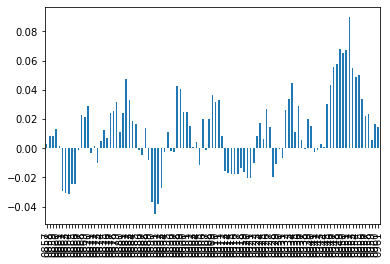

val_autocorrelation: 0.809326681273809
val_mean correlation: 0.011035057050648781
val_sharpe: 0.43529822801440515
val numerai sharpe: 0.08470844571438224
val_smart sharpe: 0.4984396892658595
current score 1.0405164770959445 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 181s 2s/step - loss: 0.0497 - mae: 0.1549 - mse: 0.0497 - val_loss: 0.0505 - val_mae: 0.1591 - val_mse: 0.0505
Epoch 43/48
100/101 [============================>.] - ETA: 19s - loss: 0.0499 - mae: 0.1585 - mse: 0.04 - ETA: 15s - loss: 0.0504 - mae: 0.1601 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1600 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1605 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1607 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1604 - mse: 0.05 - ETA: 14s - loss: 0.0505 - mae: 0.1603 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1599 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1597 - mse: 0.05 - ETA: 14s - loss: 0.0504 - mae: 0.1594 

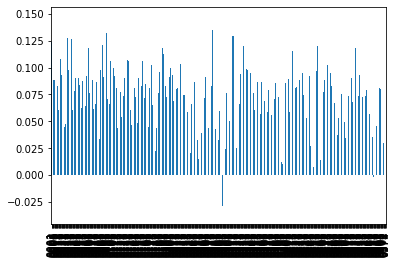

autocorrelation: 0.7626493560533203
mean correlation: 0.07325015932777698
sharpe: 2.609458328857892
numerai sharpe: 7.754147741812842
smart sharpe: 3.3247442226131554
predicting on validation
getting per val_era scores
performance over time


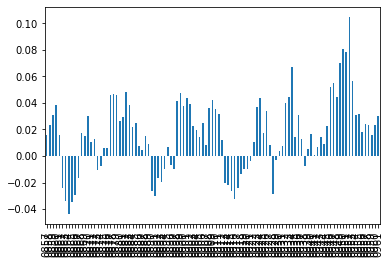

val_autocorrelation: 0.7917523230156146
val_mean correlation: 0.016311198668911363
val_sharpe: 0.5913332099191376
val numerai sharpe: 0.7404534838911522
val_smart sharpe: 0.7095040846725179
current score 2.07391317582063 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 169s 2s/step - loss: 0.0497 - mae: 0.1549 - mse: 0.0497 - val_loss: 0.0502 - val_mae: 0.1557 - val_mse: 0.0502
Epoch 44/48
100/101 [============================>.] - ETA: 19s - loss: 0.0507 - mae: 0.1565 - mse: 0.05 - ETA: 16s - loss: 0.0497 - mae: 0.1542 - mse: 0.04 - ETA: 16s - loss: 0.0499 - mae: 0.1549 - mse: 0.04 - ETA: 16s - loss: 0.0497 - mae: 0.1545 - mse: 0.04 - ETA: 15s - loss: 0.0497 - mae: 0.1546 - mse: 0.04 - ETA: 15s - loss: 0.0497 - mae: 0.1548 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1548 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1550 - mse: 0.04 - ETA: 15s - loss: 0.0499 - mae: 0.1551 - mse: 0.04 - ETA: 14s - loss: 0.0500 - mae: 0.1552 - m

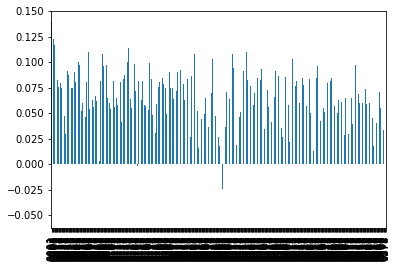

autocorrelation: 0.7615948149211088
mean correlation: 0.06590160473458678
sharpe: 2.602457785875323
numerai sharpe: 7.590410645501912
smart sharpe: 3.324121858604228
predicting on validation
getting per val_era scores
performance over time


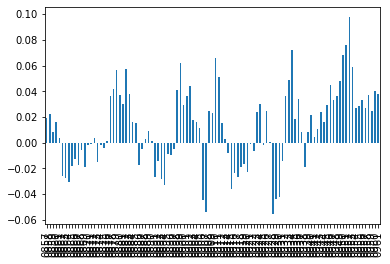

val_autocorrelation: 0.7398062543131143
val_mean correlation: 0.011612777038502697
val_sharpe: 0.38412030709109457
val numerai sharpe: 0.13722775057671466
val_smart sharpe: 0.5202892431724113
current score 1.0648628549172259 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 171s 2s/step - loss: 0.0497 - mae: 0.1546 - mse: 0.0497 - val_loss: 0.0507 - val_mae: 0.1602 - val_mse: 0.0507
Epoch 45/48
100/101 [============================>.] - ETA: 18s - loss: 0.0506 - mae: 0.1605 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1609 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1610 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1601 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1590 - mse: 0.05 - ETA: 14s - loss: 0.0502 - mae: 0.1586 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1585 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1582 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1580 - mse: 0.05 - ETA: 14s - loss: 0.0503 - mae: 0.1577

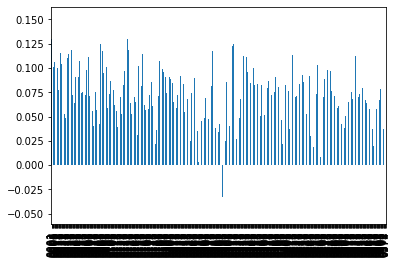

autocorrelation: 0.7613649377657153
mean correlation: 0.07178570952117164
sharpe: 2.61182066988041
numerai sharpe: 7.734923714178657
smart sharpe: 3.337894820043489
predicting on validation
getting per val_era scores
performance over time


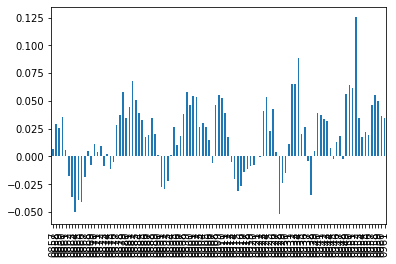

val_autocorrelation: 0.7096772218592068
val_mean correlation: 0.018115096823101716
val_sharpe: 0.5796351672285853
val numerai sharpe: 0.8534777241778804
val_smart sharpe: 0.8349233361823647
current score 2.3042664212350337 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 168s 2s/step - loss: 0.0498 - mae: 0.1545 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1558 - val_mse: 0.0502
Epoch 46/48
100/101 [============================>.] - ETA: 18s - loss: 0.0500 - mae: 0.1559 - mse: 0.05 - ETA: 16s - loss: 0.0496 - mae: 0.1554 - mse: 0.04 - ETA: 16s - loss: 0.0498 - mae: 0.1558 - mse: 0.04 - ETA: 15s - loss: 0.0496 - mae: 0.1554 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1558 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1558 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1556 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1555 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1554 - mse: 0.04 - ETA: 15s - loss: 0.0498 - mae: 0.1552 -

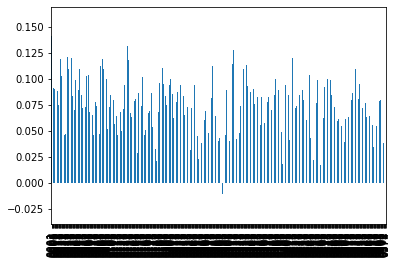

autocorrelation: 0.7377423977423031
mean correlation: 0.07454841275240444
sharpe: 2.9793178366255577
numerai sharpe: 8.878761016001594
smart sharpe: 4.017246045947216
predicting on validation
getting per val_era scores
performance over time


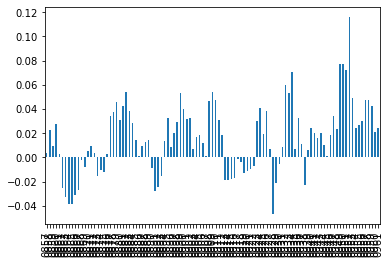

val_autocorrelation: 0.7349734317823176
val_mean correlation: 0.0156030683640994
val_sharpe: 0.5488749797446745
val numerai sharpe: 0.6321888682910904
val_smart sharpe: 0.7511010443697136
current score 1.9633710291336774 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 176s 2s/step - loss: 0.0497 - mae: 0.1545 - mse: 0.0497 - val_loss: 0.0505 - val_mae: 0.1595 - val_mse: 0.0505
Epoch 47/48
100/101 [============================>.] - ETA: 21s - loss: 0.0500 - mae: 0.1588 - mse: 0.05 - ETA: 16s - loss: 0.0500 - mae: 0.1602 - mse: 0.05 - ETA: 16s - loss: 0.0501 - mae: 0.1609 - mse: 0.05 - ETA: 15s - loss: 0.0501 - mae: 0.1604 - mse: 0.05 - ETA: 15s - loss: 0.0500 - mae: 0.1592 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1583 - mse: 0.04 - ETA: 15s - loss: 0.0500 - mae: 0.1580 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1576 - mse: 0.04 - ETA: 15s - loss: 0.0500 - mae: 0.1574 - mse: 0.05 - ETA: 15s - loss: 0.0499 - mae: 0.1571 - m

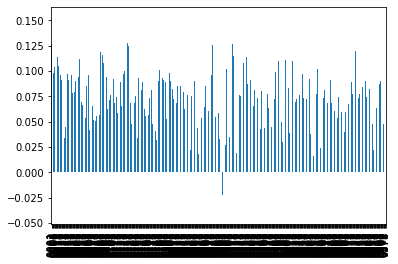

autocorrelation: 0.749884884868882
mean correlation: 0.07218042876627119
sharpe: 2.8366026952401997
numerai sharpe: 8.408413376734849
smart sharpe: 3.7228535236038285
predicting on validation
getting per val_era scores
performance over time


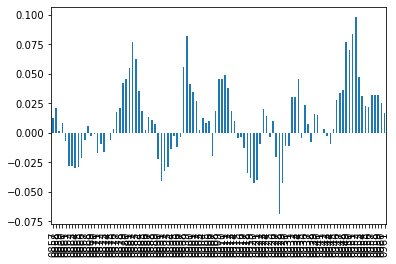

val_autocorrelation: 0.8047690556101937
val_mean correlation: 0.01072409449690081
val_sharpe: 0.35015475121391565
val numerai sharpe: 0.034943375504390924
val_smart sharpe: 0.4059708781920986
current score 0.8125171939042068 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 179s 2s/step - loss: 0.0497 - mae: 0.1547 - mse: 0.0497 - val_loss: 0.0513 - val_mae: 0.1633 - val_mse: 0.0513
Epoch 48/48
100/101 [============================>.] - ETA: 20s - loss: 0.0502 - mae: 0.1614 - mse: 0.05 - ETA: 16s - loss: 0.0509 - mae: 0.1659 - mse: 0.05 - ETA: 16s - loss: 0.0513 - mae: 0.1677 - mse: 0.05 - ETA: 16s - loss: 0.0510 - mae: 0.1662 - mse: 0.05 - ETA: 16s - loss: 0.0509 - mae: 0.1646 - mse: 0.05 - ETA: 15s - loss: 0.0508 - mae: 0.1633 - mse: 0.05 - ETA: 15s - loss: 0.0507 - mae: 0.1621 - mse: 0.05 - ETA: 15s - loss: 0.0506 - mae: 0.1611 - mse: 0.05 - ETA: 15s - loss: 0.0505 - mae: 0.1604 - mse: 0.05 - ETA: 15s - loss: 0.0504 - mae: 0.1596

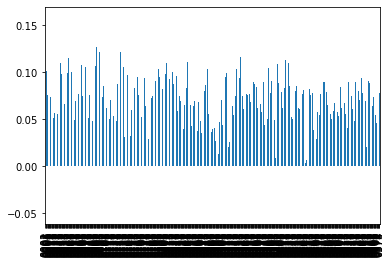

autocorrelation: 0.7673197061985781
mean correlation: 0.07210813552966122
sharpe: 2.6789582495246536
numerai sharpe: 7.939772553590385
smart sharpe: 3.3753327028881426
predicting on validation
getting per val_era scores
performance over time


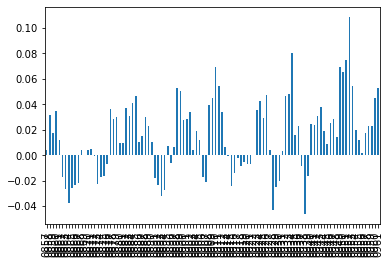

val_autocorrelation: 0.6976614092154492
val_mean correlation: 0.014483440625469928
val_sharpe: 0.5025854745196897
val numerai sharpe: 0.4890354648967618
val_smart sharpe: 0.7408664774202388
current score 1.7614542980876302 did not improve from max score 3.745026721629743 on round 30
101/101 [==============================] - 177s 2s/step - loss: 0.0498 - mae: 0.1548 - mse: 0.0498 - val_loss: 0.0502 - val_mae: 0.1554 - val_mse: 0.0502
Elapsed time: 9218.188622 seconds.



In [ ]:
#neural network model
tic()
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
input_data = Input(shape=(len(feature_names),))
x = Dense(len(feature_names), activation='relu')(input_data)
x = Dense(len(feature_names) // 2, activation='relu')(x)
x = Dense(len(feature_names) // 4, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(input_data, output)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
global roundScores
roundScores = []
callbacks = [calculateScores(training_data, validation_data, max_score_save_file)]
epochs=48
batch_size = len(training_data) // 100
model.fit(training_data[feature_names], training_data[TARGET_COL], epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(validation_data[feature_names], validation_data[TARGET_COL]), callbacks=callbacks)     
toc()

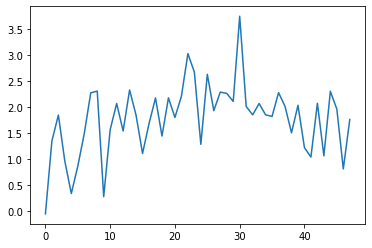

In [ ]:
plt.plot(roundScores)

In [ ]:
model = tf.keras.models.load_model(max_score_save_file)
tournament_data['prediction'] = model.predict(tournament_data[feature_names])

On validation the correlation has mean 0.018832666233168222 and std 0.02081765122930206


<AxesSubplot:xlabel='era'>

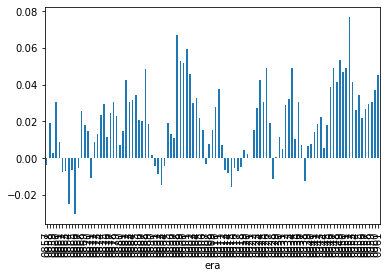

In [ ]:
# results

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def score(df):
    return correlation(df['prediction'], df[TARGET_COL])

def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)


# Check the per-era correlations on the training set (in sample)
#train_correlations = training_data.groupby("era").apply(score)
#print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")
#print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

# Check the per-era correlations on the validation set (out of sample)
validation_data['prediction'] = model.predict(validation_data[features])
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and "
        f"std {validation_correlations.std()}")
validation_correlations.plot(kind='bar')

In [ ]:
tournament_data['prediction'].to_csv(f"tournament_predictions_{current_round}.csv")
model_id = ''
submission_id = napi.upload_predictions(f"tournament_predictions_{current_round}.csv".format(current_round), model_id=model_id,version=2)

2022-05-30 00:33:21,941 INFO numerapi.base_api: uploading predictions...
